In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM
from statsmodels.graphics.factorplots import interaction_plot

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
from pingouin import ttest

from CosinorPy import file_parser, cosinor, cosinor1

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics

#dimensionality reduction
from sklearn.decomposition import PCA

#clustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from bioinfokit.visuz import cluster

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")
sns.set(font_scale=2)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Get data

## Get filtered drinking data combined with RFID (already processed in other nb)

In [2]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/polysubstance_paper/data/final/clean/VDM/VDM_poly_final_clean_231103.csv'
data_VDM_start = pd.read_csv(path)
data_VDM_start = pd.DataFrame(data = data_VDM_start)
data_VDM_start['Id'] = data_VDM_start['Sex'] + '_' + data_VDM_start['IdRFID'].astype('str')

print(data_VDM_start.shape)
data_VDM_start.head()

(84467, 56)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,RFID_days,VDM_days,Processed_2023,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,VDM_day_count,VDM_min_count,VDM_sec_count,VDM_hour_count_running,VDM_min_count_running,VDM_sec_count_running,ld_seg,day,ld_cycle,ld_day,VDM_drink,Cage_VDM_update,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,VDM_RFID_timediff,VDM_RFID_timediff_bool,substance,Id
0,0,0,0,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,53,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 21:54:01,drink_1,0.021,2022-10-10 21:54:01,1.665439e+09,2022-10-10,10,21:54:01,21,54,1,0,1314,78841,-3,-126,-7619,dark_pm,0,dark,1,VDM_EtOH05,1,25.797,041AC15ED3,etoh_05,2022-10-10 21:53:51.171993600,2022-10-10 21:54:16.968993600,0.000000,same,EtOH05,male_041AC15ED3
1,1,1,1,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,72,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/11/22 03:16:20,drink_1,0.021,2022-10-11 03:16:20,1.665458e+09,2022-10-11,11,03:16:20,3,16,20,1,196,11780,3,196,11720,dark_am,1,dark,1,VDM_EtOH05,1,2.374,041AC15ED3,etoh_05,2022-10-11 03:11:22.796044800,2022-10-11 03:11:25.170044800,294.829955,diff,EtOH05,male_041AC15ED3
2,2,2,2,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,235,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/11/22 20:37:46,drink_1,0.021,2022-10-11 20:37:46,1.665521e+09,2022-10-11,11,20:37:46,20,37,46,1,1237,74266,20,1237,74206,dark_pm,1,dark,2,VDM_EtOH05,1,21.541,041AC15ED3,etoh_05,2022-10-11 20:37:28.550985600,2022-10-11 20:37:50.091985600,0.000000,same,EtOH05,male_041AC15ED3
3,3,3,3,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,263,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/13/22 13:33:35,drink_1,0.021,2022-10-13 13:33:35,1.665668e+09,2022-10-13,13,13:33:35,13,33,35,3,813,48815,61,3693,221555,light,3,light,3,VDM_EtOH05,1,3.978,041AC15ED3,etoh_05,2022-10-13 12:11:38.272963200,2022-10-13 12:11:42.250963200,4912.749036,diff,EtOH05,male_041AC15ED3
4,4,4,4,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,273,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/14/22 06:28:01,drink_1,0.021,2022-10-14 06:28:01,1.665729e+09,2022-10-14,14,06:28:01,6,28,1,4,388,23281,78,4708,282421,light,4,light,4,VDM_EtOH05,1,1.259,041AC15ED3,etoh_05,2022-10-14 06:19:52.405017600,2022-10-14 06:19:53.664017600,487.335982,diff,EtOH05,male_041AC15ED3


In [3]:
data_VDM_start.groupby(['IdRFID'])['ld_day'].max()

IdRFID
041ABFE4E6    8 
041ABFE86A    10
041ABFEA34    10
041ABFEE18    9 
041ABFFA62    10
041AC001FC    9 
041AC004D1    8 
041AC01110    10
041AC01C83    9 
041AC02E82    10
041AC02F19    8 
041AC03290    9 
041AC15DE9    10
041AC15DF7    10
041AC15E0E    8 
041AC15E98    8 
041AC15ECB    8 
041AC15ECD    8 
041AC15ED3    9 
041AC15FD5    12
041AC160C0    9 
041AC160F9    9 
041AC1617F    9 
041AC1620E    8 
041AC162AC    8 
041AC162F0    10
041AC16317    9 
041AC16321    10
041AC1635B    10
041AC1637F    10
041AC163D0    12
041AC16447    8 
041AC1646E    9 
041AC1646F    9 
041AC16486    9 
041AC16499    8 
041AC1649B    8 
041AC164CB    10
041AC16530    8 
041AC16548    12
041AC16579    12
041AC165A6    10
041AC165B6    10
041AC165C6    8 
041AC165FE    9 
041AC16672    10
041AC1667D    8 
041AC166BB    8 
041AC166C2    10
041AC166D7    9 
041AC166ED    12
041AC1677D    9 
041AC16782    9 
041AC1678E    8 
041AC1682D    9 
041AC1689B    8 
041AC168BD    9 
041AC169DC    9 
041AC16

In [4]:
#some got taken out on 8th day 
data_VDM_start = data_VDM_start[data_VDM_start['ld_day']<8]
data_VDM_start = data_VDM_start[data_VDM_start['ld_day']>0]
data_VDM_start = data_VDM_start[data_VDM_start['VDM_RFID_timediff']<3]
data_VDM_start = data_VDM_start[data_VDM_start['Cage_N']>1]

data_VDM_start['intake_ml_kg'] = data_VDM_start['value'] / (data_VDM_start['weight_pre']/1000)

data_VDM_start.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,RFID_days,VDM_days,Processed_2023,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,VDM_day_count,VDM_min_count,VDM_sec_count,VDM_hour_count_running,VDM_min_count_running,VDM_sec_count_running,ld_seg,day,ld_cycle,ld_day,VDM_drink,Cage_VDM_update,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,VDM_RFID_timediff,VDM_RFID_timediff_bool,substance,Id,intake_ml_kg
0,0,0,0,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,53,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 21:54:01,drink_1,0.021,2022-10-10 21:54:01,1.665439e+09,2022-10-10,10,21:54:01,21,54,1,0,1314,78841,-3,-126,-7619,dark_pm,0,dark,1,VDM_EtOH05,1,25.797,041AC15ED3,etoh_05,2022-10-10 21:53:51.171993600,2022-10-10 21:54:16.968993600,0.000000,same,EtOH05,male_041AC15ED3,0.739437
2,2,2,2,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,235,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/11/22 20:37:46,drink_1,0.021,2022-10-11 20:37:46,1.665521e+09,2022-10-11,11,20:37:46,20,37,46,1,1237,74266,20,1237,74206,dark_pm,1,dark,2,VDM_EtOH05,1,21.541,041AC15ED3,etoh_05,2022-10-11 20:37:28.550985600,2022-10-11 20:37:50.091985600,0.000000,same,EtOH05,male_041AC15ED3,0.739437
12,12,12,12,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,386,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/11/22 05:08:47,drink_2,0.021,2022-10-11 05:08:47,1.665465e+09,2022-10-11,11,05:08:47,5,8,47,1,308,18527,5,308,18467,dark_am,1,dark,1,VDM_EtOH10,1,15.162,041AC15ED3,etoh_10,2022-10-11 05:08:45.227990400,2022-10-11 05:09:00.389990400,0.000000,same,EtOH10,male_041AC15ED3,0.739437
13,13,13,13,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,3484,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/12/22 21:08:31,drink_2,0.021,2022-10-12 21:08:31,1.665609e+09,2022-10-12,12,21:08:31,21,8,31,2,1268,76111,45,2708,162451,dark_pm,2,dark,3,VDM_EtOH10,1,0.075,041AC15ED3,etoh_10,2022-10-12 21:08:30.294988800,2022-10-12 21:08:30.369988800,0.630011,diff,EtOH10,male_041AC15ED3,0.739437
14,14,14,14,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,9756,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/13/22 21:27:42,drink_2,0.021,2022-10-13 21:27:42,1.665696e+09,2022-10-13,13,21:27:42,21,27,42,3,1287,77262,69,4167,250002,dark_pm,3,dark,4,VDM_EtOH10,1,18.466,041AC15ED3,etoh_10,2022-10-13 21:27:37.946966400,2022-10-13 21:27:56.412966400,0.000000,same,EtOH10,male_041AC15ED3,0.739437


In [5]:
hour_to_zeit = {0:19,
                1:20,
                2:21,
                3:22,
                4:23,
                5:24,
                6:1,
                7:2,
                8:3,
                9:4,
                10:5,
                11:6,
                12:7,
                13:8,
                14:9,
                15:10,
                16:11,
                17:12,
                18:13,
                19:14,
                20:15,
                21:16,
                22:17,
                23:18,
               }

data_VDM_start['zeitgeber'] = data_VDM_start['VDM_hour'].map(hour_to_zeit)

In [6]:
len(data_VDM_start[data_VDM_start['Sex']=='female']['IdRFID'].unique())

24

In [7]:
len(data_VDM_start[data_VDM_start['Sex']=='male']['IdRFID'].unique())

32

In [8]:
data_VDM_start.shape

(46091, 58)

In [9]:
data_VDM_total_ld_day_hour = data_VDM_start.groupby(['IdRFID', 'Sex', 'substance', 'ld_cycle', 'zeitgeber', 'ld_day',
                                   ])['intake_ml_kg'].sum().reset_index()

print(data_VDM_total_ld_day_hour.shape)
data_VDM_total_ld_day_hour.head()

(6561, 7)


,IdRFID,Sex,substance,ld_cycle,zeitgeber,ld_day,intake_ml_kg
0,041ABFE4E6,male,EtOH05,dark,15,2,0.761246
1,041ABFE4E6,male,EtOH10,dark,15,4,0.830450
2,041ABFE4E6,male,EtOH10,dark,15,5,0.830450
3,041ABFE4E6,male,Fent05,dark,14,2,0.934256
4,041ABFE4E6,male,Fent05,dark,15,2,0.934256


In [10]:
substances = ['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20']
data_final = pd.DataFrame()

for IdRFID in data_VDM_total_ld_day_hour['IdRFID'].unique():
    print(IdRFID)
    
    d_animal = data_VDM_total_ld_day_hour[data_VDM_total_ld_day_hour['IdRFID']==IdRFID]
    
    for substance in substances:
        
        days_hours_df = pd.DataFrame(0, index=np.arange(1,8), columns=data_VDM_start['zeitgeber'].unique()).unstack().reset_index()
        days_hours_df.columns = ['zeitgeber', 'ld_day', 'ddd']
        days_hours_df['ld_cycle'] = ['light' if x<13 else 'dark' for x in days_hours_df['zeitgeber']]
        days_hours_df['substance'] = substance
        days_hours_df['IdRFID'] = IdRFID
        days_hours_df['Sex'] = d_animal['Sex'].values[0]
        
        x = days_hours_df.merge(d_animal, on=['IdRFID', 'Sex', 'ld_day', 'ld_cycle', 'zeitgeber', 'substance'], 
                                how='left').sort_values(['substance', 'ld_day', 'zeitgeber'])
        
        if data_final.empty:
            data_final = x
        else:
            data_final = pd.concat([data_final, x], axis=0)
        
    print(data_final.shape,'\n')

data_final = data_final.fillna(0).sort_values(['IdRFID', 'substance', 'ld_day', 'zeitgeber'])
data_final.head()

041ABFE4E6
(840, 8) 

041ABFE86A
(1680, 8) 

041ABFEA34
(2520, 8) 

041ABFEE18
(3360, 8) 

041ABFFA62
(4200, 8) 

041AC001FC
(5040, 8) 

041AC004D1
(5880, 8) 

041AC01110
(6720, 8) 

041AC02E82
(7560, 8) 

041AC02F19
(8400, 8) 

041AC15DE9
(9240, 8) 

041AC15DF7
(10080, 8) 

041AC15E0E
(10920, 8) 

041AC15E98
(11760, 8) 

041AC15ECB
(12600, 8) 

041AC15ECD
(13440, 8) 

041AC15ED3
(14280, 8) 

041AC15FD5
(15120, 8) 

041AC160C0
(15960, 8) 

041AC1617F
(16800, 8) 

041AC1620E
(17640, 8) 

041AC162AC
(18480, 8) 

041AC162F0
(19320, 8) 

041AC16317
(20160, 8) 

041AC16321
(21000, 8) 

041AC1635B
(21840, 8) 

041AC1637F
(22680, 8) 

041AC16447
(23520, 8) 

041AC1646E
(24360, 8) 

041AC1646F
(25200, 8) 

041AC16486
(26040, 8) 

041AC16499
(26880, 8) 

041AC1649B
(27720, 8) 

041AC164CB
(28560, 8) 

041AC16530
(29400, 8) 

041AC16548
(30240, 8) 

041AC165A6
(31080, 8) 

041AC165B6
(31920, 8) 

041AC165C6
(32760, 8) 

041AC165FE
(33600, 8) 

041AC16672
(34440, 8) 

041AC1667D
(35280, 8) 

041A

,zeitgeber,ld_day,ddd,ld_cycle,substance,IdRFID,Sex,intake_ml_kg
56,1,1,0,light,EtOH05,041ABFE4E6,male,0.0
126,2,1,0,light,EtOH05,041ABFE4E6,male,0.0
63,3,1,0,light,EtOH05,041ABFE4E6,male,0.0
98,4,1,0,light,EtOH05,041ABFE4E6,male,0.0
140,5,1,0,light,EtOH05,041ABFE4E6,male,0.0


## Get RFID data (already processed in other nb)

In [11]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/polysubstance_paper/data/final/clean/RFID/RFID_poly_final_clean_231103.csv'

data_RFID_start = pd.read_csv(path)
data_RFID_start = pd.DataFrame(data = data_RFID_start)
print(data_RFID_start.shape)
data_RFID_start.head()

(689058, 34)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes
0,0,0,0,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_05,Spyder1.10,1.474,light,0,0,15,14,24,2022-06-01 15:14:24.644976000,2022-06-01 15:14:26.118976000,15:14:24,15:14:26,914,54864,-9,-526,-31596,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
1,1,1,1,poly,na,1,041AC15FD5,1866.0,na,male,3,water_2,Spyder1.05,1.832,light,0,0,15,15,6,2022-06-01 15:15:06.097017600,2022-06-01 15:15:07.929017600,15:15:06,15:15:07,915,54906,-9,-525,-31554,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
2,2,2,2,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_05,Spyder1.04,0.887,light,0,0,15,15,44,2022-06-01 15:15:44.613014400,2022-06-01 15:15:45.500014400,15:15:44,15:15:45,915,54944,-9,-525,-31516,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
3,3,3,3,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,0.414,light,0,0,15,16,6,2022-06-01 15:16:06.479990400,2022-06-01 15:16:06.893990400,15:16:06,15:16:06,916,54966,-9,-524,-31494,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
4,4,4,4,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_20,Spyder1.01,2.777,light,0,0,15,16,18,2022-06-01 15:16:18.455980800,2022-06-01 15:16:21.232980800,15:16:18,15:16:21,916,54978,-9,-524,-31482,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN


In [12]:
data_RFID_start.groupby(['IdRFID'])['ld_day'].max()

IdRFID
041ABFE4E6    8 
041ABFE86A    10
041ABFEA34    10
041ABFEE18    9 
041ABFFA62    10
041AC001FC    9 
041AC004D1    8 
041AC01110    10
041AC01C83    9 
041AC02E82    10
041AC02F19    8 
041AC03290    9 
041AC15DE9    10
041AC15DF7    10
041AC15E0E    8 
041AC15E98    8 
041AC15ECB    8 
041AC15ECD    8 
041AC15ED3    9 
041AC15FD5    12
041AC160C0    9 
041AC160F9    9 
041AC1617F    9 
041AC1620E    8 
041AC162AC    8 
041AC162F0    10
041AC16317    9 
041AC16321    10
041AC1635B    10
041AC1637F    10
041AC163D0    12
041AC16447    8 
041AC1646E    9 
041AC1646F    9 
041AC16486    9 
041AC16499    8 
041AC1649B    8 
041AC164CB    10
041AC16530    8 
041AC16548    12
041AC16579    12
041AC165A6    10
041AC165B6    10
041AC165C6    8 
041AC165FE    9 
041AC16672    10
041AC1667D    8 
041AC166BB    8 
041AC166C2    10
041AC166D7    9 
041AC166ED    12
041AC1677D    9 
041AC16782    9 
041AC1678E    8 
041AC1682D    9 
041AC1689B    8 
041AC168BD    9 
041AC169DC    9 
041AC16

In [13]:
#some got taken out on 8th day so end at lights on day 8
data_RFID_start = data_RFID_start[data_RFID_start['ld_day']<8]
data_RFID_start = data_RFID_start[data_RFID_start['ld_day']>0]

data_RFID_start = data_RFID_start[data_RFID_start['Cage_N']>1]
print(data_RFID_start.shape)
data_RFID_start.head()

(418699, 34)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes
231,231,231,231,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,23.391,dark,1,0,18,0,23,2022-06-01 18:00:23.085993600,2022-06-01 18:00:46.476993600,18:00:23,18:00:46,1080,64823,-6,-360,-21637,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
232,232,232,232,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,3.372,dark,1,0,18,0,47,2022-06-01 18:00:47.591971200,2022-06-01 18:00:50.963971200,18:00:47,18:00:50,1080,64847,-6,-360,-21613,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
233,233,233,233,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,1.743,dark,1,0,18,0,52,2022-06-01 18:00:52.367040000,2022-06-01 18:00:54.110040000,18:00:52,18:00:54,1080,64852,-6,-360,-21608,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
234,234,234,234,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_20,Spyder1.01,16.418,dark,1,0,18,8,21,2022-06-01 18:08:21.301958400,2022-06-01 18:08:37.719958400,18:08:21,18:08:37,1088,65301,-6,-352,-21159,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
235,235,235,235,poly,na,1,041AC15FD5,1866.0,na,male,3,water_1,Spyder1.02,3.860,dark,1,0,18,9,18,2022-06-01 18:09:18.525024000,2022-06-01 18:09:22.385024000,18:09:18,18:09:22,1089,65358,-6,-351,-21102,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN


In [14]:
hour_to_zeit = {0:19,
                1:20,
                2:21,
                3:22,
                4:23,
                5:24,
                6:1,
                7:2,
                8:3,
                9:4,
                10:5,
                11:6,
                12:7,
                13:8,
                14:9,
                15:10,
                16:11,
                17:12,
                18:13,
                19:14,
                20:15,
                21:16,
                22:17,
                23:18,
               }

data_RFID_start['zeitgeber'] = data_RFID_start['RFID_hour'].map(hour_to_zeit)

## Confirm matching RFIDs 

In [15]:
set(data_RFID_start['IdRFID'].unique()) - set(data_VDM_start['IdRFID'].unique())

set()

In [16]:
set(data_VDM_start['IdRFID'].unique()) - set(data_RFID_start['IdRFID'].unique())

set()

In [17]:
sub_map = {'etoh_05': 'EtOH05',
           'etoh_10': 'EtOH10',
           'fent_05': 'Fent05',
           'fent_20': 'Fent20',
           'water_1': 'water',
           'water_2': 'water',}

data_RFID_start['substance'] = data_RFID_start['unitLabel_drink'].map(sub_map)

In [18]:
data_RFID_total_ld_day_hour = data_RFID_start.groupby(['IdRFID', 'Sex', 'substance', 'ld_cycle', 'zeitgeber', 'ld_day',
                                   ])['eventDuration'].sum().reset_index()

print(data_RFID_total_ld_day_hour.shape)
data_RFID_total_ld_day_hour.head()

(30203, 7)


,IdRFID,Sex,substance,ld_cycle,zeitgeber,ld_day,eventDuration
0,041ABFE4E6,male,EtOH05,dark,13,1,54.216
1,041ABFE4E6,male,EtOH05,dark,13,2,68.672
2,041ABFE4E6,male,EtOH05,dark,13,3,32.353
3,041ABFE4E6,male,EtOH05,dark,13,4,2.771
4,041ABFE4E6,male,EtOH05,dark,13,5,2.746


In [19]:
substances = ['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20']
data_RFID_final = pd.DataFrame()

for IdRFID in data_RFID_total_ld_day_hour['IdRFID'].unique():
    print(IdRFID)
    
    d_animal = data_RFID_total_ld_day_hour[data_RFID_total_ld_day_hour['IdRFID']==IdRFID]
    
    for substance in substances:
        
        days_hours_df = pd.DataFrame(0, index=np.arange(1,8), columns=data_RFID_start['zeitgeber'].unique()).unstack().reset_index()
        days_hours_df.columns = ['zeitgeber', 'ld_day', 'ddd']
        days_hours_df['ld_cycle'] = ['light' if x<13 else 'dark' for x in days_hours_df['zeitgeber']]
        days_hours_df['substance'] = substance
        days_hours_df['IdRFID'] = IdRFID
        days_hours_df['Sex'] = d_animal['Sex'].values[0]
        
        x = days_hours_df.merge(d_animal, on=['IdRFID', 'Sex', 'ld_day', 'ld_cycle', 'zeitgeber', 'substance'], 
                                how='left').sort_values(['substance', 'ld_day', 'zeitgeber'])
        
        if data_RFID_final.empty:
            data_RFID_final = x
        else:
            data_RFID_final = pd.concat([data_RFID_final, x], axis=0)
        
    print(data_RFID_final.shape,'\n')

data_RFID_final = data_RFID_final.fillna(0).sort_values(['IdRFID', 'substance', 'ld_day', 'zeitgeber'])
data_RFID_final.head()

041ABFE4E6
(840, 8) 

041ABFE86A
(1680, 8) 

041ABFEA34
(2520, 8) 

041ABFEE18
(3360, 8) 

041ABFFA62
(4200, 8) 

041AC001FC
(5040, 8) 

041AC004D1
(5880, 8) 

041AC01110
(6720, 8) 

041AC02E82
(7560, 8) 

041AC02F19
(8400, 8) 

041AC15DE9
(9240, 8) 

041AC15DF7
(10080, 8) 

041AC15E0E
(10920, 8) 

041AC15E98
(11760, 8) 

041AC15ECB
(12600, 8) 

041AC15ECD
(13440, 8) 

041AC15ED3
(14280, 8) 

041AC15FD5
(15120, 8) 

041AC160C0
(15960, 8) 

041AC1617F
(16800, 8) 

041AC1620E
(17640, 8) 

041AC162AC
(18480, 8) 

041AC162F0
(19320, 8) 

041AC16317
(20160, 8) 

041AC16321
(21000, 8) 

041AC1635B
(21840, 8) 

041AC1637F
(22680, 8) 

041AC16447
(23520, 8) 

041AC1646E
(24360, 8) 

041AC1646F
(25200, 8) 

041AC16486
(26040, 8) 

041AC16499
(26880, 8) 

041AC1649B
(27720, 8) 

041AC164CB
(28560, 8) 

041AC16530
(29400, 8) 

041AC16548
(30240, 8) 

041AC165A6
(31080, 8) 

041AC165B6
(31920, 8) 

041AC165C6
(32760, 8) 

041AC165FE
(33600, 8) 

041AC16672
(34440, 8) 

041AC1667D
(35280, 8) 

041A

,zeitgeber,ld_day,ddd,ld_cycle,substance,IdRFID,Sex,eventDuration
77,1,1,0,light,EtOH05,041ABFE4E6,male,9.074
84,2,1,0,light,EtOH05,041ABFE4E6,male,0.000
91,3,1,0,light,EtOH05,041ABFE4E6,male,5.823
133,4,1,0,light,EtOH05,041ABFE4E6,male,0.000
98,5,1,0,light,EtOH05,041ABFE4E6,male,0.344


In [20]:
data_RFID = data_RFID_final

## Behav baseline data

In [21]:
path_behav = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/polysubstance_paper/meta/RFID_VDM_behavior.xlsx'

data_behav = pd.read_excel(path_behav)
data_behav = pd.DataFrame(data = data_behav)
data_behav = data_behav[data_behav['IdRFID'].isin(data_RFID_total_ld_day_hour['IdRFID'].unique())]
data_behav['Id'] = data_behav['Sex'] + '_' + data_behav['IdRFID'].astype('str')

print(data_behav.shape)
data_behav.head()

(56, 25)


,Cohort,Behavior_Date,RFID_VDM_Date,Cage,IdRFID,Animal,ARF_cage,Sex,Cage_N,Weight,RFID_VDM_notes,Notes,EZM_distance,EZM_speed,EZM_OAE,EZM_OAT,EZM_OAD,EZM_OAL,OFB_distance,OFB_speed,OFB_CE,OFB_CT,OFB_CD,OFB_CL,Id
0,1,22.04.18,22.04.20,1,041AC162AC,1822,549,male,3,28.0,NaN,sim,5.299,0.018,13.0,31.8,0.249,0.0,33.164,0.111,28.0,66.0,9.867,0.0,male_041AC162AC
1,1,22.04.18,22.04.20,1,041AC16AE3,1823,549,male,3,27.8,NaN,NaN,6.942,0.023,24.0,46.2,0.832,0.0,25.964,0.087,17.0,25.6,4.490,17.3,male_041AC16AE3
2,1,22.04.18,22.04.20,1,041AC165C6,1824,549,male,3,28.7,NaN,sim,8.898,0.030,15.0,139.0,3.860,0.0,28.521,0.095,11.0,17.2,3.440,51.6,male_041AC165C6
3,1,22.04.18,22.04.20,3,041AC166BB,1825,550,male,3,26.8,NaN,NaN,8.426,0.028,11.0,9.3,0.088,22.5,26.825,0.089,14.0,32.7,3.750,0.3,male_041AC166BB
4,1,22.04.18,22.04.20,3,041AC1620E,1826,550,male,3,26.0,NaN,NaN,5.692,0.019,9.0,12.1,0.111,1.3,26.324,0.088,10.0,13.2,2.400,69.1,male_041AC1620E


### stats on behavior male vs. female

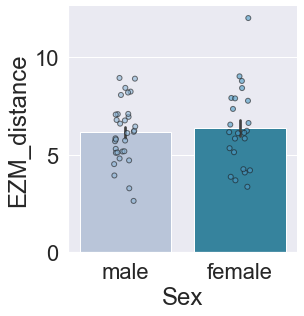

Ttest_indResult(statistic=0.4254240608372534, pvalue=0.6722182546714717)


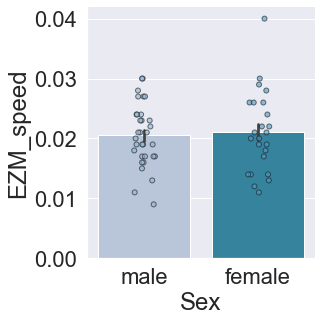

Ttest_indResult(statistic=0.3443318644255052, pvalue=0.7319340940048846)


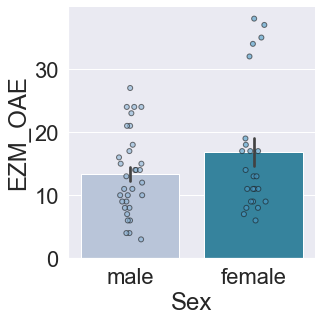

Ttest_indResult(statistic=1.5265495796710251, pvalue=0.13270945460404576)


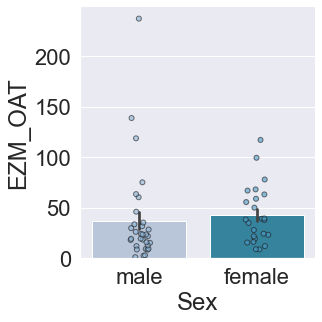

Ttest_indResult(statistic=0.49726079841328763, pvalue=0.6210238680649584)


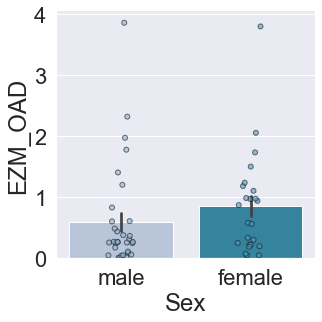

Ttest_indResult(statistic=1.090409767376154, pvalue=0.28037453887431796)


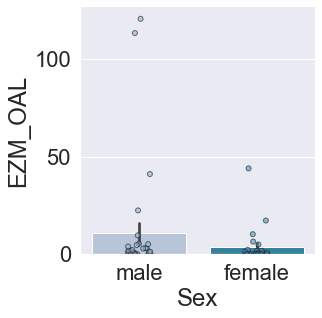

Ttest_indResult(statistic=-1.1485668999006884, pvalue=0.2557970450150076)


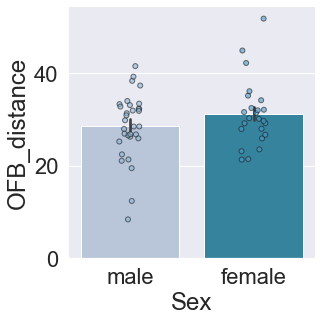

Ttest_indResult(statistic=1.3353277924199556, pvalue=0.18737089011765526)


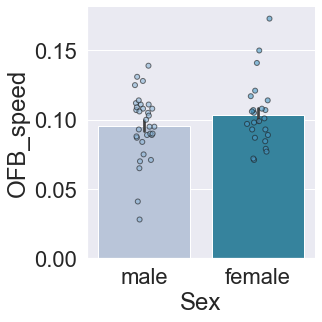

Ttest_indResult(statistic=1.2153070798631322, pvalue=0.22953588463188224)


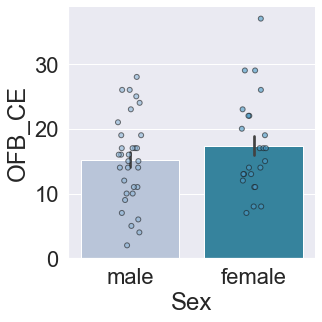

Ttest_indResult(statistic=1.145537860328675, pvalue=0.25703791223437705)


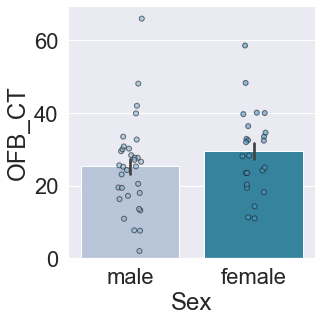

Ttest_indResult(statistic=1.2905884705823696, pvalue=0.20234503532661363)


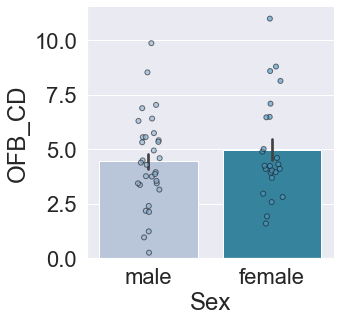

Ttest_indResult(statistic=0.9093921800382946, pvalue=0.3671843161298085)


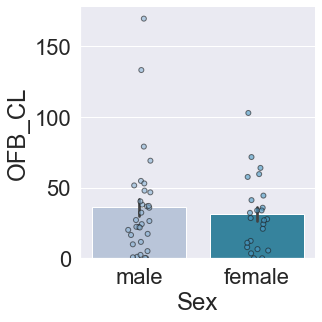

Ttest_indResult(statistic=-0.5408276148341461, pvalue=0.5908504682234035)


In [22]:
params = ['EZM_distance', 'EZM_speed', 'EZM_OAE', 'EZM_OAT',
       'EZM_OAD', 'EZM_OAL', 'OFB_distance', 'OFB_speed', 'OFB_CE',
       'OFB_CT', 'OFB_CD', 'OFB_CL']

for param in params:

    g = sns.catplot(x='Sex', y=param, data=data_behav,  kind='bar', 
                    ci=68, height=5, aspect=1, palette='PuBuGn')
    # map data to stripplot
    g.map(sns.stripplot, 'Sex', param,
          palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)
    plt.ylabel(param)
    plt.show()

    male = data_behav[data_behav['Sex']=='male'][param]
    female = data_behav[data_behav['Sex']=='female'][param]
    print(stats.ttest_ind(female, male))

### cor viz

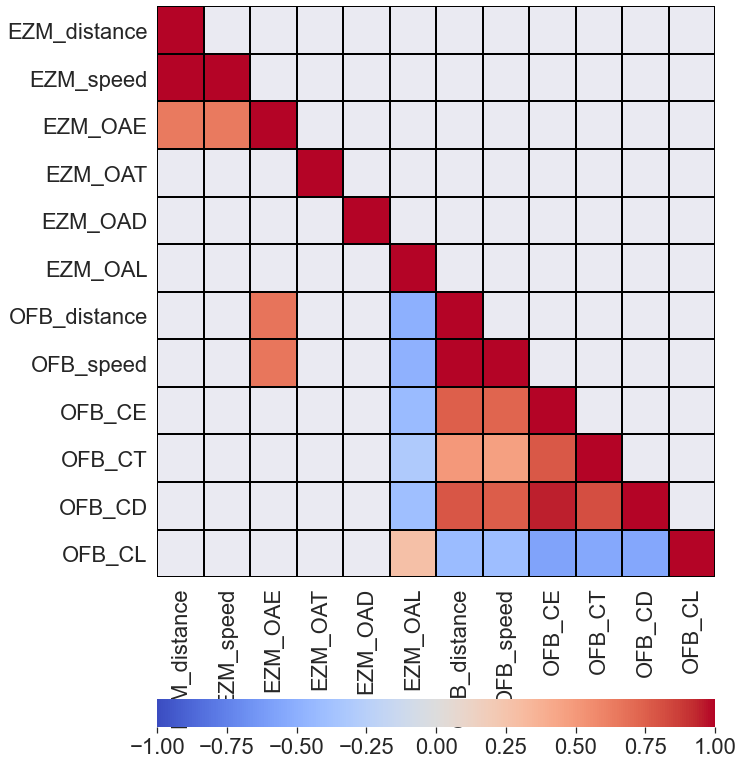

In [23]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(10,15))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=False, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=1, linecolor='black', cbar_kws={'orientation': 'horizontal'})


# Plotting with significance filter  
corr = data_behav[params].corr()
p_values = corr_sig(corr)                     # get p-Value
mask = np.invert(np.tril(p_values<0.01))    # mask - only get significant corr
plot_cor_matrix(corr,mask)  

plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

plt.show()


### cluster viz

<Figure size 1080x2160 with 0 Axes>

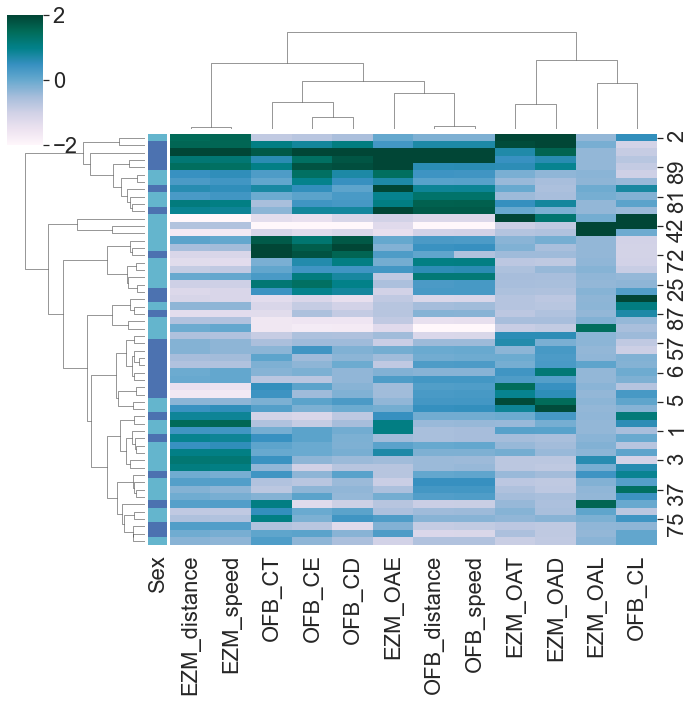

In [24]:
sns.color_palette("flare", as_cmap=True)

lut = dict(zip(data_behav['Sex'].unique(), "cb"))
row_colors = data_behav['Sex'].map(lut)
plt.figure(figsize=(15,30))

g = sns.clustermap(data_behav[params].dropna(axis=0), row_colors=row_colors,
                 metric="euclidean", z_score=1, method="ward",
               vmin=-2, vmax=2, center=0, cmap = 'PuBuGn', 
               square=True, cbar_kws={"shrink": .5}, figsize=(10,10))
plt.show()

# Behavior PCA then cluster

## PCA

In [25]:
#dimensionality reduction
from sklearn.decomposition import PCA

feat_df = data_behav[['EZM_distance', 'EZM_speed', 'EZM_OAE', 'EZM_OAT',
       'EZM_OAD', 'EZM_OAL', 'OFB_distance', 'OFB_speed', 'OFB_CE',
       'OFB_CT', 'OFB_CD', 'OFB_CL',]]

df_st =  StandardScaler().fit_transform(feat_df)  

pca_out = PCA().fit(df_st)

pca_out.explained_variance_ratio_

array([0.48092781, 0.16746079, 0.13190918, 0.06991394, 0.05767688,
       0.04039235, 0.02679764, 0.01260288, 0.00878355, 0.00316688,
       0.00027472, 0.00009337])

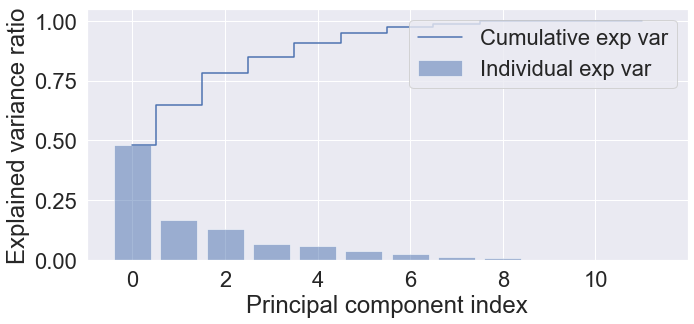

In [26]:
exp_var_pca = pca_out.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.figure(figsize=(10,5))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual exp var')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative exp var')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [27]:
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['substance'] = feat_df.columns.values
loadings_df = loadings_df.set_index('substance')
loadings_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
substance,,,,,,,,,,,,
EZM_distance,0.257190,0.334245,-0.475318,0.096259,-0.083781,-0.117048,-0.207376,-0.013928,0.151883,-0.012664,-0.037696,-0.705955
EZM_speed,0.256163,0.337520,-0.474157,0.103413,-0.085441,-0.108102,-0.207271,-0.019545,0.149786,0.008291,0.058199,0.704783
EZM_OAE,0.326257,0.144312,-0.186731,-0.167181,0.239869,-0.184872,0.779454,0.202378,-0.261674,0.030924,-0.015850,0.003335
EZM_OAT,0.063707,0.471820,0.533954,0.140658,0.033137,-0.096072,0.149684,0.255614,0.608309,-0.012111,0.013286,-0.000366
EZM_OAD,0.157604,0.505844,0.315394,0.336673,-0.124217,0.253094,-0.050324,-0.245955,-0.601557,-0.042261,-0.016346,-0.004909


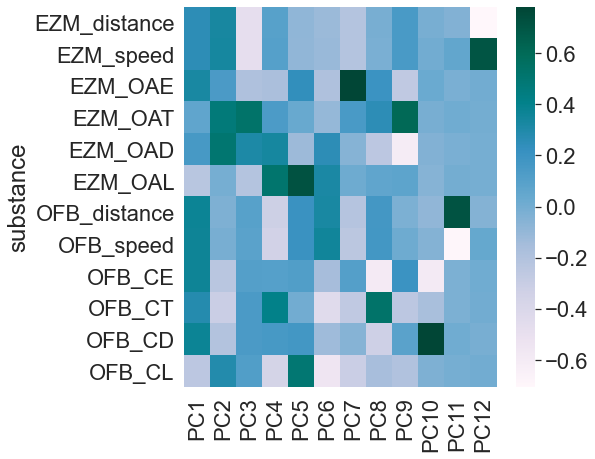

In [28]:
plt.figure(figsize=(7,7))
ax = sns.heatmap(loadings_df, annot=False, cmap='PuBuGn')
plt.show()

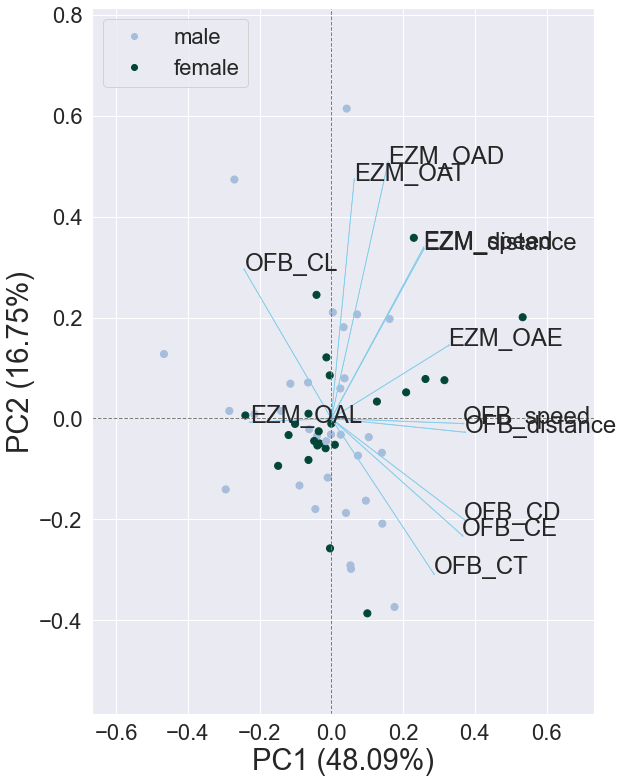

In [29]:
# get PC scores
pca_scores = PCA().fit_transform(df_st)

from bioinfokit.visuz import cluster

# get 2D biplot
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=feat_df.columns.values, 
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
               show=True, dim=(9,13), axlabelfontsize=29,
               colordot=["#A6BDDB", "#014636"],
              colorlist=data_behav['Sex'], legendpos='upper left', dotsize=50)

In [30]:
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
id_scores_df = pd.DataFrame.from_dict(pca_scores)
id_scores_df.columns = pc_list
id_scores_df['IdRFID'] = data_behav['IdRFID'].values

print(id_scores_df.shape)
id_scores_df.head()

(56, 13)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,IdRFID
0,2.683096,-2.931503,1.277969,1.496169,0.149719,-1.144579,-0.634485,0.310855,0.049246,0.358437,-0.093458,0.053770,041AC162AC
1,0.384484,0.466294,-0.544560,0.273719,-0.557415,-0.406300,1.145422,-0.020390,-0.026435,0.006979,-0.046912,-0.011179,041AC16AE3
2,0.653783,4.819286,0.855146,1.159530,-0.889411,0.371192,-0.382491,-0.335609,-0.426433,-0.049397,0.023863,0.020315,041AC165C6
3,-0.014212,-0.248463,-2.101453,1.057158,-0.607082,0.077977,-0.549250,0.483148,0.527466,-0.154757,0.023069,-0.008714,041AC166BB
4,-2.130370,0.116660,-0.479502,-1.240613,-0.207635,-0.167487,-0.351908,-0.244760,-0.112985,-0.051082,0.010995,0.010714,041AC1620E


## Cluster

In [31]:
data_behav_PCA = data_behav.merge(id_scores_df, on='IdRFID')

print(data_behav_PCA.shape)
data_behav_PCA.head()

(56, 37)


,Cohort,Behavior_Date,RFID_VDM_Date,Cage,IdRFID,Animal,ARF_cage,Sex,Cage_N,Weight,RFID_VDM_notes,Notes,EZM_distance,EZM_speed,EZM_OAE,EZM_OAT,EZM_OAD,EZM_OAL,OFB_distance,OFB_speed,OFB_CE,OFB_CT,OFB_CD,OFB_CL,Id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,1,22.04.18,22.04.20,1,041AC162AC,1822,549,male,3,28.0,NaN,sim,5.299,0.018,13.0,31.8,0.249,0.0,33.164,0.111,28.0,66.0,9.867,0.0,male_041AC162AC,2.683096,-2.931503,1.277969,1.496169,0.149719,-1.144579,-0.634485,0.310855,0.049246,0.358437,-0.093458,0.053770
1,1,22.04.18,22.04.20,1,041AC16AE3,1823,549,male,3,27.8,NaN,NaN,6.942,0.023,24.0,46.2,0.832,0.0,25.964,0.087,17.0,25.6,4.490,17.3,male_041AC16AE3,0.384484,0.466294,-0.544560,0.273719,-0.557415,-0.406300,1.145422,-0.020390,-0.026435,0.006979,-0.046912,-0.011179
2,1,22.04.18,22.04.20,1,041AC165C6,1824,549,male,3,28.7,NaN,sim,8.898,0.030,15.0,139.0,3.860,0.0,28.521,0.095,11.0,17.2,3.440,51.6,male_041AC165C6,0.653783,4.819286,0.855146,1.159530,-0.889411,0.371192,-0.382491,-0.335609,-0.426433,-0.049397,0.023863,0.020315
3,1,22.04.18,22.04.20,3,041AC166BB,1825,550,male,3,26.8,NaN,NaN,8.426,0.028,11.0,9.3,0.088,22.5,26.825,0.089,14.0,32.7,3.750,0.3,male_041AC166BB,-0.014212,-0.248463,-2.101453,1.057158,-0.607082,0.077977,-0.549250,0.483148,0.527466,-0.154757,0.023069,-0.008714
4,1,22.04.18,22.04.20,3,041AC1620E,1826,550,male,3,26.0,NaN,NaN,5.692,0.019,9.0,12.1,0.111,1.3,26.324,0.088,10.0,13.2,2.400,69.1,male_041AC1620E,-2.130370,0.116660,-0.479502,-1.240613,-0.207635,-0.167487,-0.351908,-0.244760,-0.112985,-0.051082,0.010995,0.010714


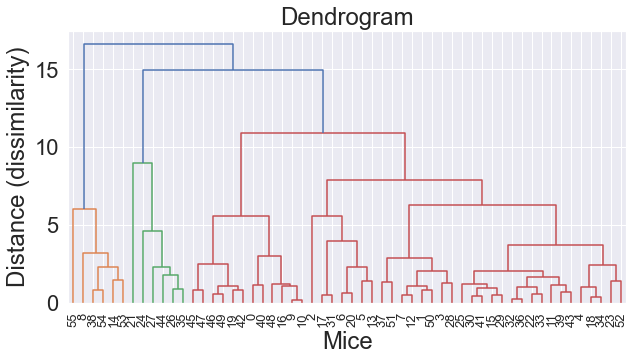

In [32]:
#viz dendrogram to find if three clusters makes sense
plt.figure(figsize=(10, 5))  
plt.title("Dendrogram")  
plt.ylabel("Distance (dissimilarity)")
plt.xlabel("Mice")
dend = shc.dendrogram(shc.linkage(data_behav_PCA[['PC1', 'PC2', 'PC3']], method='ward'), 
                      distance_sort='ascending', 
                      show_leaf_counts=True, leaf_font_size=13)

In [33]:
def kmeans_stability(data, k):
    
    ####determine cluster stability - bootstrap starting random state - e.g. different cluster initialization 
    
    scores = {}
    
    homogeneity_score_list = []
    completeness_score_list = []
    v_measure_score_list = []
    adjusted_rand_score_list = []
    adjusted_mutual_info_score_list = []
    
    #create initial cluster as baseline comparison
    km_orig = KMeans(n_clusters=k, random_state=39)
    km_orig.fit(data)
    orig_clusters = km_orig.labels_

    #bootstrap random state and compare to baseline cluster
    for i in range(1,99,3):

        #fit
        km_int = KMeans(n_clusters=k, random_state=i)
        km_int.fit(data)
        int_clusters = km_int.labels_
    
        #compute metrics
        homogeneity_score_int = metrics.homogeneity_score(orig_clusters, int_clusters)
        completeness_score_int = metrics.completeness_score(orig_clusters, int_clusters)
        v_measure_score_int = metrics.v_measure_score(orig_clusters, int_clusters)
        adjusted_rand_score_int = metrics.adjusted_rand_score(orig_clusters, int_clusters)
        adjusted_mutual_info_score_int = metrics.adjusted_mutual_info_score(orig_clusters,  int_clusters)
    
        homogeneity_score_list.append(homogeneity_score_int)
        completeness_score_list.append(completeness_score_int)
        v_measure_score_list.append(v_measure_score_int)
        adjusted_rand_score_list.append(adjusted_rand_score_int)
        adjusted_mutual_info_score_list.append(adjusted_mutual_info_score_int)
    
    scores['homogeneity_score'] = homogeneity_score_list
    scores['completeness_score'] = completeness_score_list
    scores['v_measure_score'] = v_measure_score_list
    scores['adjusted_rand_score'] = adjusted_rand_score_list
    scores['adjusted_mutual_info_score'] = adjusted_mutual_info_score_list
    
    return scores

In [34]:
scores_k2 = pd.DataFrame.from_dict(kmeans_stability(data_behav_PCA[['PC1', 'PC2', 'PC3']], 2)).mean()
scores_k3 = pd.DataFrame.from_dict(kmeans_stability(data_behav_PCA[['PC1', 'PC2', 'PC3']], 3)).mean()
scores_k4 = pd.DataFrame.from_dict(kmeans_stability(data_behav_PCA[['PC1', 'PC2', 'PC3']], 4)).mean()
scores_k5 = pd.DataFrame.from_dict(kmeans_stability(data_behav_PCA[['PC1', 'PC2', 'PC3']], 5)).mean()
scores_k6 = pd.DataFrame.from_dict(kmeans_stability(data_behav_PCA[['PC1', 'PC2', 'PC3']], 6)).mean()

cluster_scores = pd.DataFrame(data=[scores_k2, scores_k3, scores_k4, scores_k5, scores_k6], index=['k=2', 'k=3', 'k=4', 'k=5', 'k=6']).reset_index()

cluster_scores

,index,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
0,k=2,0.913160,0.919373,0.916192,0.941598,0.914894
1,k=3,0.791905,0.665436,0.722518,0.705359,0.706324
2,k=4,0.758318,0.740460,0.749131,0.719714,0.727003
3,k=5,0.772205,0.772233,0.771790,0.671462,0.741427
4,k=6,0.744119,0.776311,0.759427,0.629933,0.716105


<AxesSubplot:xlabel='index', ylabel='homogeneity_score'>

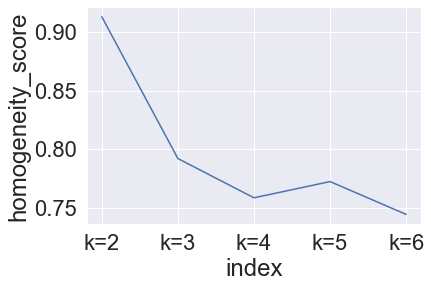

In [35]:
sns.lineplot(data=cluster_scores, x='index', y='homogeneity_score')

In [36]:
#choose k=3 clusters and fit data
km_3 = KMeans(n_clusters=3,random_state=99)
km_3.fit(data_behav_PCA[['PC1', 'PC2', 'PC3']])

data_behav_PCA['kmeans_cluster'] = ["cluster_" + str(label) for label in km_3.labels_ ]
print(data_behav_PCA.shape)
data_behav_PCA.head(1)

(56, 38)


,Cohort,Behavior_Date,RFID_VDM_Date,Cage,IdRFID,Animal,ARF_cage,Sex,Cage_N,Weight,RFID_VDM_notes,Notes,EZM_distance,EZM_speed,EZM_OAE,EZM_OAT,EZM_OAD,EZM_OAL,OFB_distance,OFB_speed,OFB_CE,OFB_CT,OFB_CD,OFB_CL,Id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,kmeans_cluster
0,1,22.04.18,22.04.20,1,041AC162AC,1822,549,male,3,28.0,NaN,sim,5.299,0.018,13.0,31.8,0.249,0.0,33.164,0.111,28.0,66.0,9.867,0.0,male_041AC162AC,2.683096,-2.931503,1.277969,1.496169,0.149719,-1.144579,-0.634485,0.310855,0.049246,0.358437,-0.093458,0.05377,cluster_2


In [37]:
data_behav_PCA.to_csv('data_behav_PCA.csv')

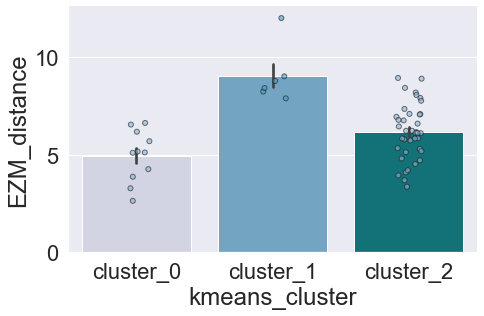

F_onewayResult(statistic=16.600876065078612, pvalue=2.5242599140610446e-06)


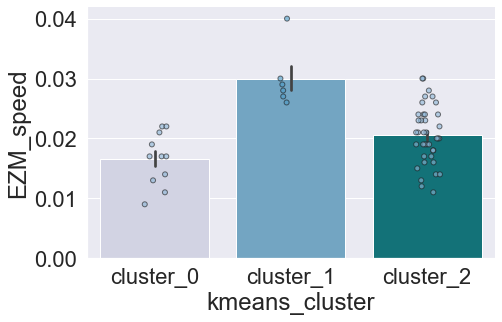

F_onewayResult(statistic=15.690170798120736, pvalue=4.445459373288335e-06)


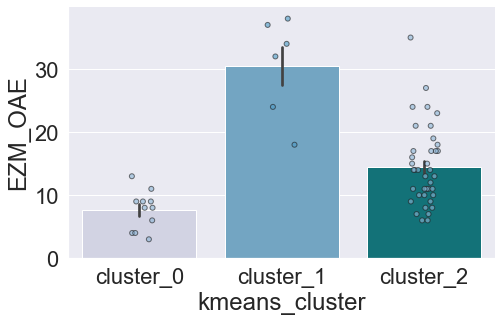

F_onewayResult(statistic=28.28637736439096, pvalue=4.377157446025083e-09)


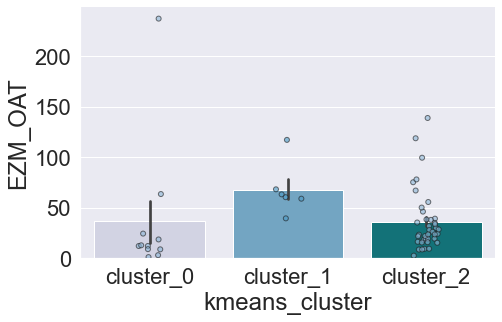

F_onewayResult(statistic=1.6743622976460226, pvalue=0.19718875418082202)


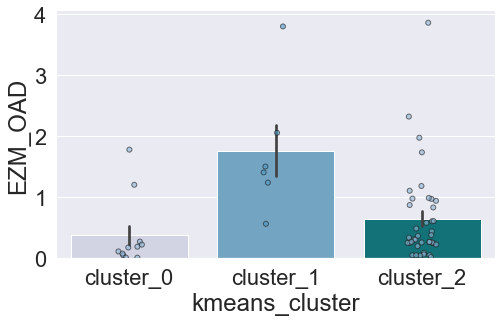

F_onewayResult(statistic=6.863214203922674, pvalue=0.0022357165333220315)


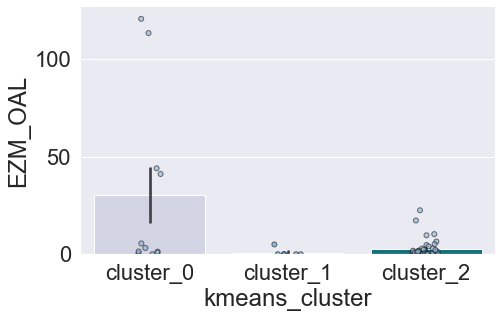

F_onewayResult(statistic=8.201458979932735, pvalue=0.0007884981773453049)


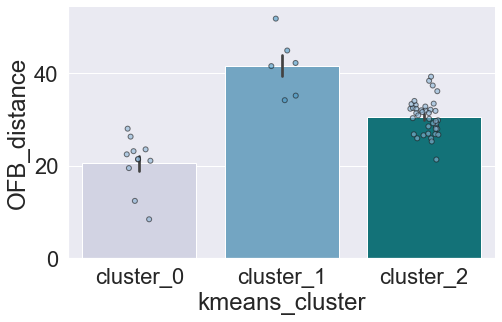

F_onewayResult(statistic=44.1471918282871, pvalue=5.188008900316801e-12)


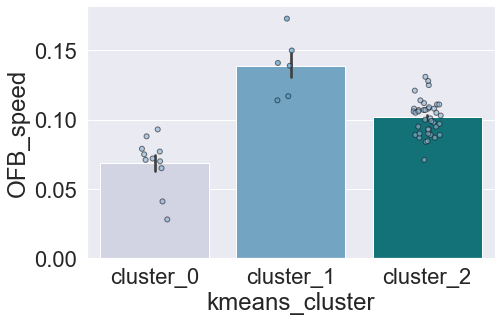

F_onewayResult(statistic=42.71207974117494, pvalue=8.93707336914568e-12)


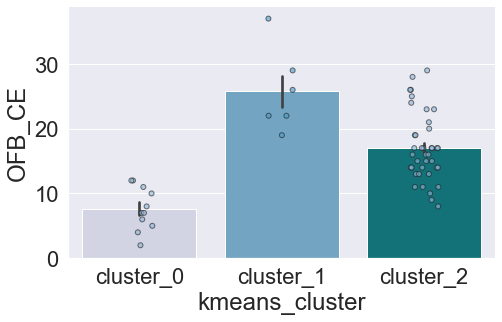

F_onewayResult(statistic=26.758360812118777, pvalue=9.26273152707778e-09)


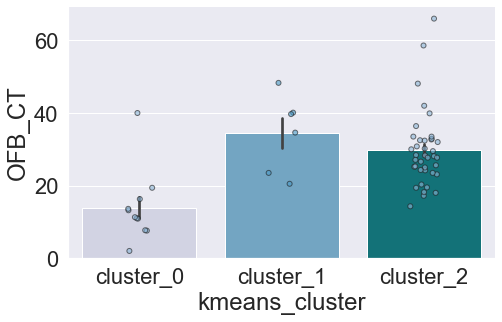

F_onewayResult(statistic=11.829505117586729, pvalue=5.654387156292349e-05)


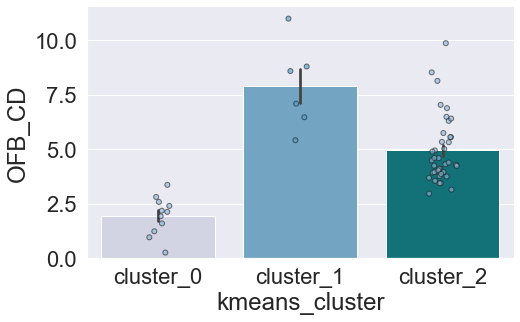

F_onewayResult(statistic=32.909342368662365, pvalue=5.115227070349053e-10)


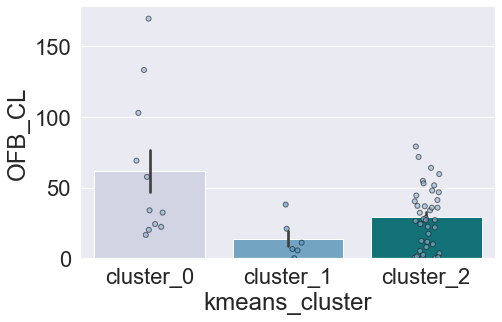

F_onewayResult(statistic=7.002125525037471, pvalue=0.002002617834879039)


In [38]:
params = ['EZM_distance', 'EZM_speed', 'EZM_OAE', 'EZM_OAT',
       'EZM_OAD', 'EZM_OAL', 'OFB_distance', 'OFB_speed', 'OFB_CE',
       'OFB_CT', 'OFB_CD', 'OFB_CL']
cluster_order = ['cluster_0', 'cluster_1', 'cluster_2']
for param in params:

    g = sns.catplot(x='kmeans_cluster', y=param, data=data_behav_PCA,  kind='bar', 
                    ci=68, height=5, aspect=1.5, palette='PuBuGn', order=cluster_order)
    # map data to stripplot
    g.map(sns.stripplot, 'kmeans_cluster', param, order=cluster_order,
          palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)
    plt.ylabel(param)
    plt.show()
    
    a=data_behav_PCA[data_behav_PCA['kmeans_cluster']=='cluster_0'][param].values
    b=data_behav_PCA[data_behav_PCA['kmeans_cluster']=='cluster_1'][param].values
    c=data_behav_PCA[data_behav_PCA['kmeans_cluster']=='cluster_2'][param].values
    print(f_oneway(a, b, c))

<AxesSubplot:xlabel='kmeans_cluster', ylabel='count'>

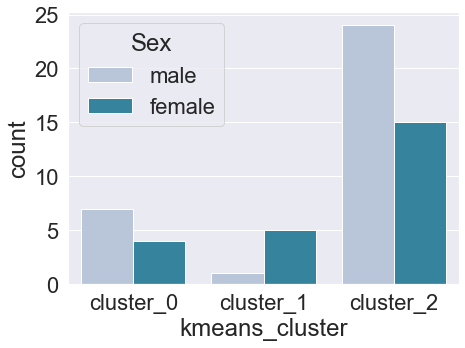

In [39]:
plt.figure(figsize=(7, 5))  

sns.countplot(x='kmeans_cluster', data=data_behav_PCA, hue='Sex', palette="PuBuGn", order=cluster_order)

In [40]:
data_behav_PCA_count = data_behav_PCA.groupby(['Sex'])['kmeans_cluster'].value_counts().reset_index(name='count')

data_behav_PCA_count2 = data_behav_PCA['Sex'].value_counts().reset_index(name='count')

data_behav_PCA_count = data_behav_PCA_count.merge(data_behav_PCA_count2, left_on='Sex', right_on='index')

data_behav_PCA_count['kmeans_perc'] = data_behav_PCA_count['count_x'] / data_behav_PCA_count['count_y'] * 100

data_behav_PCA_count

,Sex,kmeans_cluster,count_x,index,count_y,kmeans_perc
0,female,cluster_2,15,female,24,62.500000
1,female,cluster_1,5,female,24,20.833333
2,female,cluster_0,4,female,24,16.666667
3,male,cluster_2,24,male,32,75.000000
4,male,cluster_0,7,male,32,21.875000
5,male,cluster_1,1,male,32,3.125000


In [41]:
data_behav_PCA_count.sort_values(['Sex', 'kmeans_cluster'])

,Sex,kmeans_cluster,count_x,index,count_y,kmeans_perc
2,female,cluster_0,4,female,24,16.666667
1,female,cluster_1,5,female,24,20.833333
0,female,cluster_2,15,female,24,62.500000
4,male,cluster_0,7,male,32,21.875000
5,male,cluster_1,1,male,32,3.125000
3,male,cluster_2,24,male,32,75.000000


In [42]:
table = np.array([[4, 5, 15], [7, 1, 24]])
chi2_contingency(table)


(4.510975135975136,
 0.10482242321699532,
 2,
 array([[ 4.71428571,  2.57142857, 16.71428571],
        [ 6.28571429,  3.42857143, 22.28571429]]))

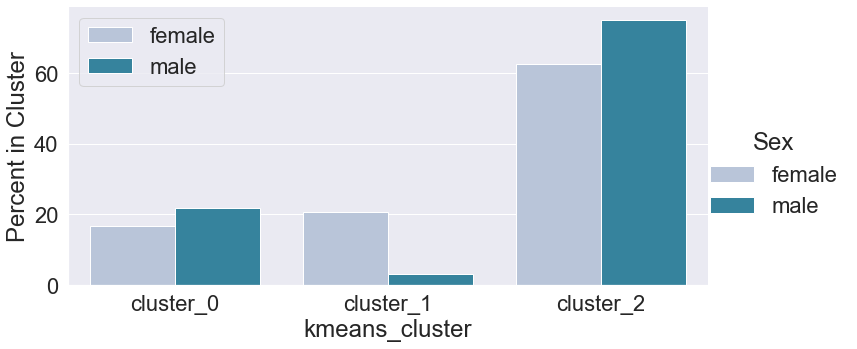

In [43]:
g = sns.catplot(x='kmeans_cluster', y='kmeans_perc', data=data_behav_PCA_count,  kind='bar', hue='Sex',
                    ci=68, height=5, aspect=2, palette='PuBuGn', order=cluster_order)
plt.legend(loc='upper left')
plt.ylabel('Percent in Cluster')
plt.show()

# Project clusters back onto RFID data

In [44]:
cluster_order = ['cluster_0', 'cluster_1', 'cluster_2']
drink_order=['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20']


In [45]:
data_RFID = data_behav_PCA[['IdRFID', 'kmeans_cluster']].merge(data_RFID, on='IdRFID')
data_RFID_start = data_behav_PCA[['IdRFID', 'kmeans_cluster']].merge(data_RFID_start, on='IdRFID')

data_RFID.head()

,IdRFID,kmeans_cluster,zeitgeber,ld_day,ddd,ld_cycle,substance,Sex,eventDuration
0,041AC162AC,cluster_2,1,1,0,light,EtOH05,male,0.0
1,041AC162AC,cluster_2,2,1,0,light,EtOH05,male,0.0
2,041AC162AC,cluster_2,3,1,0,light,EtOH05,male,0.0
3,041AC162AC,cluster_2,4,1,0,light,EtOH05,male,0.0
4,041AC162AC,cluster_2,5,1,0,light,EtOH05,male,0.0


## total with combined substances

### event duration proportion

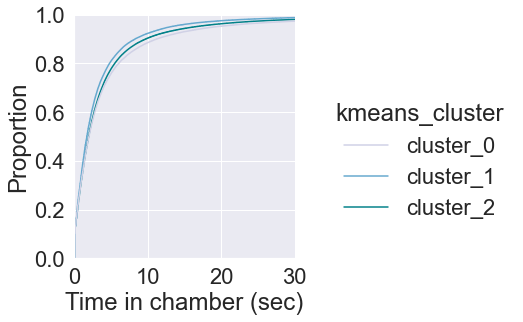

In [46]:
sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='kmeans_cluster', palette='PuBuGn',
            hue_order=cluster_order)
#plt.ylim(0,2000)
plt.xlim(0,30)
plt.xlabel('Time in chamber (sec)')

plt.show()

### total event duration sum

In [47]:
data_RFID_total = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total['Time in chamber (min)'] = data_RFID_total['eventDuration']/60

data_RFID_total.head()

,IdRFID,kmeans_cluster,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,31133.893,518.898217
1,041ABFE86A,cluster_0,21828.612,363.810200
2,041ABFEA34,cluster_2,59333.517,988.891950
3,041ABFEE18,cluster_2,39985.779,666.429650
4,041ABFFA62,cluster_2,59079.255,984.654250


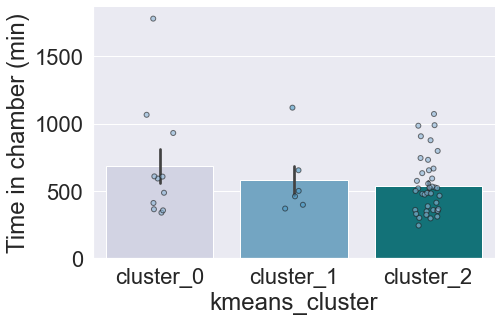

F_onewayResult(statistic=1.2248900295141798, pvalue=0.30197090880456917)


In [48]:
g = sns.catplot(x='kmeans_cluster', y='Time in chamber (min)', data=data_RFID_total,  kind='bar', height=5, aspect=1.5,
            ci=68, palette='PuBuGn', order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'kmeans_cluster', 'Time in chamber (min)', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, order=cluster_order)

plt.show()

param = 'Time in chamber (min)'
a=data_RFID_total[data_RFID_total['kmeans_cluster']=='cluster_0'][param].values
b=data_RFID_total[data_RFID_total['kmeans_cluster']=='cluster_1'][param].values
c=data_RFID_total[data_RFID_total['kmeans_cluster']=='cluster_2'][param].values
print(f_oneway(a, b, c))

## light dark with combined substances

### event duration proportion

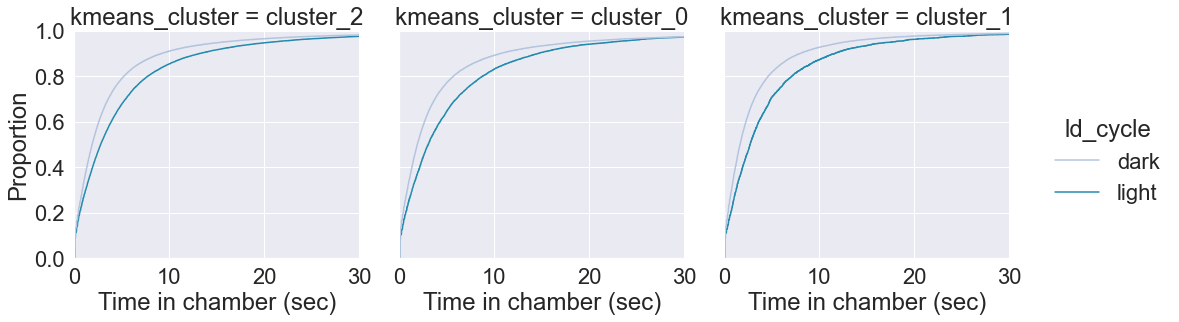

In [49]:
g=sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='ld_cycle', 
              col='kmeans_cluster', palette='PuBuGn', col_order=cluster_order)
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [50]:
data_RFID_total_ld = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 'ld_cycle', 
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_ld['Time in chamber (min)'] = data_RFID_total_ld['eventDuration']/60

data_RFID_total_ld.head()

,IdRFID,kmeans_cluster,ld_cycle,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,dark,26774.308,446.238467
1,041ABFE4E6,cluster_2,light,4359.585,72.659750
2,041ABFE86A,cluster_0,dark,18711.761,311.862683
3,041ABFE86A,cluster_0,light,3116.851,51.947517
4,041ABFEA34,cluster_2,dark,51561.580,859.359667


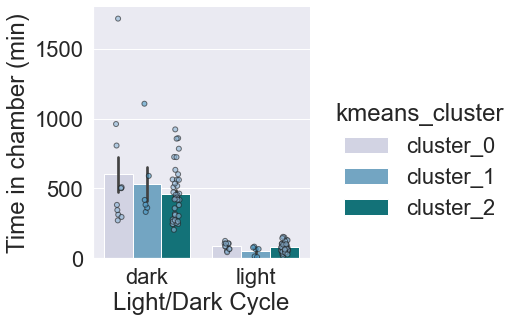

In [51]:
g= sns.catplot(x='ld_cycle', y='Time in chamber (min)', data=data_RFID_total_ld,  kind='bar', height=5, aspect=1,
            ci=68, hue='kmeans_cluster', palette='PuBuGn', hue_order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'ld_cycle', 'Time in chamber (min)', 'kmeans_cluster', hue_order=cluster_order,
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)

plt.xlabel('Light/Dark Cycle')
plt.show()

In [52]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_cycle', between='kmeans_cluster', subject='IdRFID', data=data_RFID_total_ld)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_cycle', between='kmeans_cluster',
                              subject='IdRFID', data=data_RFID_total_ld, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                   SS    DF1    DF2           MS        F    p-unc    np2      eps
--------------  -----------  -----  -----  -----------  -------  -------  -----  -------
kmeans_cluster    92461.099      2     53    46230.550    1.225    0.302  0.044  nan
ld_cycle        4917653.693      1     53  4917653.693  151.308    0.000  0.741    1.000
Interaction       86600.369      2     53    43300.184    1.332    0.273  0.048  nan


POST HOC TESTS

Contrast                   ld_cycle    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust                   BF10    hedges
-------------------------  ----------  ---------  ---------  --------  ------------  ------  ------  ---------  -------  --------  ----------  -------------------  --------
ld_cycle                   -           dark       light      True      True          12.227  55.000  two-sided    0.000   nan      nan         227000000000000.000     2.210
kmeans_clu

## daily total with combined substance 

### event duration proportion

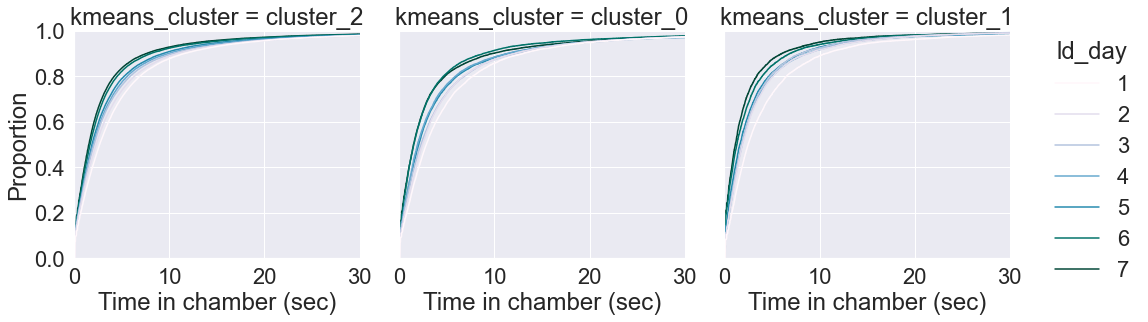

In [53]:
g=sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='ld_day', col='kmeans_cluster', 
              palette='PuBuGn', col_order=cluster_order)
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [54]:
data_RFID_total_daily = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 'ld_day',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_daily['Time in chamber (min)'] = data_RFID_total_daily['eventDuration']/60

data_RFID_total_daily.head()

,IdRFID,kmeans_cluster,ld_day,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,1,6546.483,109.108050
1,041ABFE4E6,cluster_2,2,5569.302,92.821700
2,041ABFE4E6,cluster_2,3,4080.473,68.007883
3,041ABFE4E6,cluster_2,4,3097.784,51.629733
4,041ABFE4E6,cluster_2,5,4329.275,72.154583


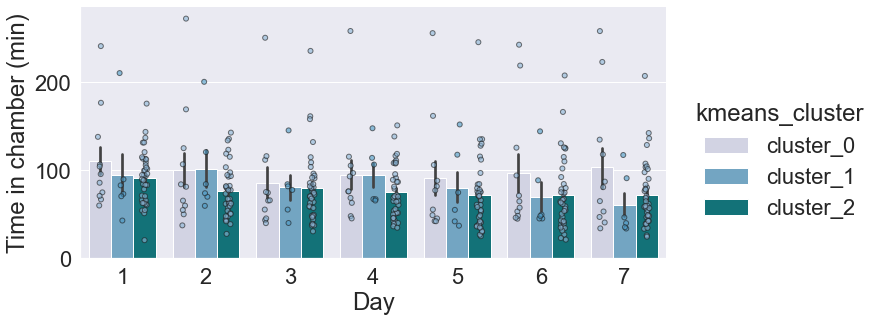

In [55]:
g= sns.catplot(x='ld_day', y='Time in chamber (min)', data=data_RFID_total_daily,  kind='bar', height=5, aspect=2,
            ci=68, hue='kmeans_cluster', palette='PuBuGn', hue_order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'ld_day', 'Time in chamber (min)', 'kmeans_cluster',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, hue_order=cluster_order)

plt.xlabel('Day')
plt.show()

In [56]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='kmeans_cluster', subject='IdRFID', data=data_RFID_total_daily)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='kmeans_cluster',
                              subject='IdRFID', data=data_RFID_total_daily, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                 SS    DF1    DF2         MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
--------------  ---------  -----  -----  ---------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
kmeans_cluster  26417.457      2     53  13208.728  1.225    0.302      nan      0.044  nan           nan        nan        nan
ld_day          15246.728      6    318   2541.121  5.782    0.000        0.001  0.098    0.460         0.000      0.045      0.000
Interaction      8555.334     12    318    712.944  1.622    0.084      nan      0.058  nan           nan        nan        nan


POST HOC TESTS

Contrast                 ld_day    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust       BF10    hedges
-----------------------  --------  ---------  ---------  --------  ------------  ------  ------  ---------  -------  --------  ----------  -------  --------


## hourly total with combined substances

### event duration proportion

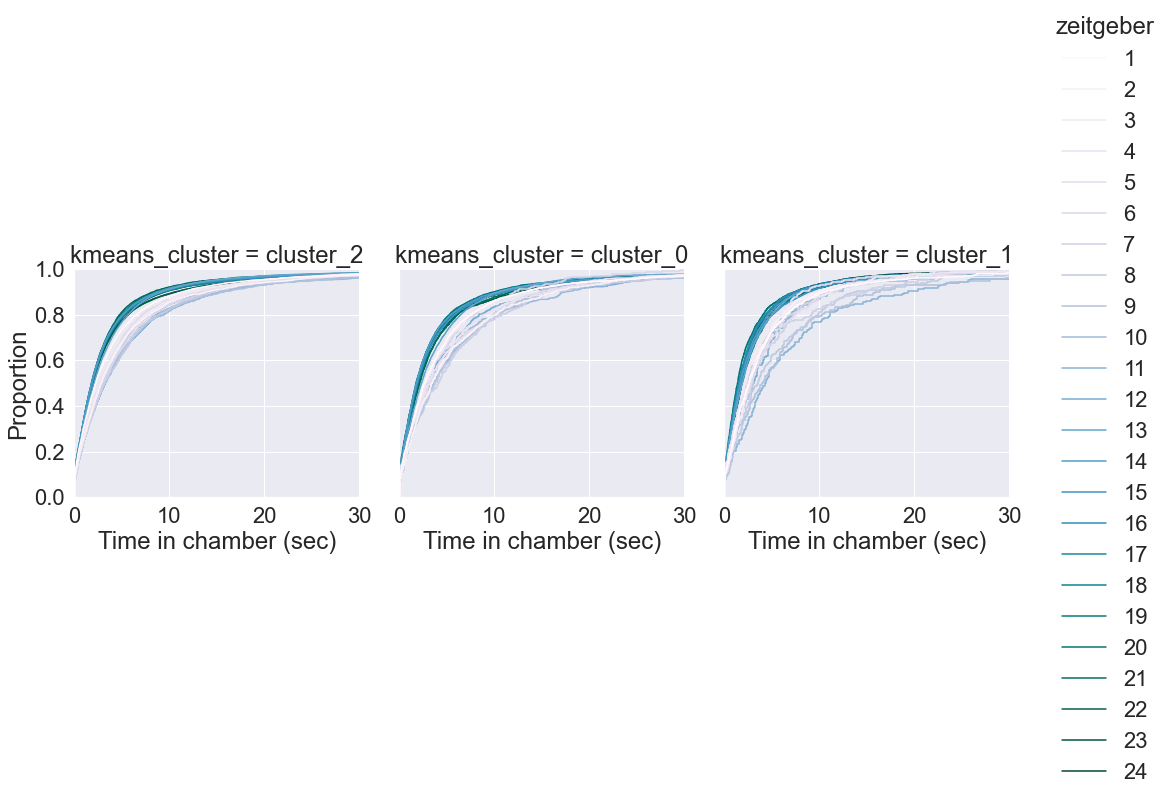

In [57]:
g=sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='zeitgeber', col='kmeans_cluster', 
              palette='PuBuGn', col_order=cluster_order)
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [58]:
data_RFID_total_hourly = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 'zeitgeber', 
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_hourly['Time in chamber (min)'] = data_RFID_total_hourly['eventDuration']/60

data_RFID_total_hourly.head()

,IdRFID,kmeans_cluster,zeitgeber,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,1,1026.680,17.111333
1,041ABFE4E6,cluster_2,2,638.714,10.645233
2,041ABFE4E6,cluster_2,3,238.381,3.973017
3,041ABFE4E6,cluster_2,4,113.320,1.888667
4,041ABFE4E6,cluster_2,5,309.242,5.154033


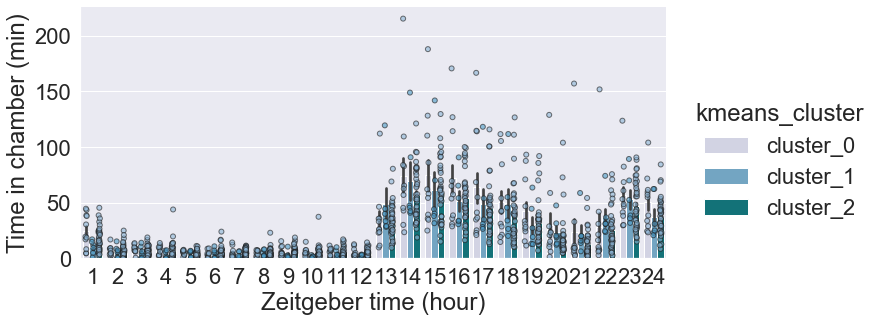

In [59]:
g= sns.catplot(x='zeitgeber', y='Time in chamber (min)', data=data_RFID_total_hourly,  kind='bar', height=5, aspect=2,
            ci=68, hue='kmeans_cluster', palette='PuBuGn', hue_order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'zeitgeber', 'Time in chamber (min)', 'kmeans_cluster', hue_order=cluster_order,
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1,
      )

plt.xlabel('Zeitgeber time (hour)')
plt.show()

In [60]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='zeitgeber', between='kmeans_cluster', subject='IdRFID', data=data_RFID_total_hourly)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='zeitgeber', between='kmeans_cluster',
                              subject='IdRFID', data=data_RFID_total_hourly, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                  SS    DF1    DF2         MS        F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
--------------  ----------  -----  -----  ---------  -------  -------  -----------  -----  -------  ------------  ---------  ---------
kmeans_cluster    7705.092      2     53   3852.546    1.225    0.302      nan      0.044  nan           nan        nan        nan
zeitgeber       564313.439     23   1219  24535.367  103.644    0.000        0.000  0.662    0.119         0.000      0.000      0.000
Interaction      13537.575     46   1219    294.295    1.243    0.130      nan      0.045  nan           nan        nan        nan


POST HOC TESTS

Contrast                    zeitgeber    A          B          Paired    Parametric          T     dof  Tail         p-unc    p-corr  p-adjust                       BF10    hedges
--------------------------  -----------  ---------  ---------  --------  ------------  -------  ------  ---------  ----

## daily and hourly combined substances heatmap

In [61]:
data_RFID_total_hour_day = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 'zeitgeber', 'ld_day',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_hour_day['Time in chamber (min)'] = data_RFID_total_hour_day['eventDuration']/60

data_RFID_total_hour_day.head()

,IdRFID,kmeans_cluster,zeitgeber,ld_day,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,1,1,81.002,1.350033
1,041ABFE4E6,cluster_2,1,2,399.488,6.658133
2,041ABFE4E6,cluster_2,1,3,0.000,0.000000
3,041ABFE4E6,cluster_2,1,4,106.825,1.780417
4,041ABFE4E6,cluster_2,1,5,69.442,1.157367


### event duration

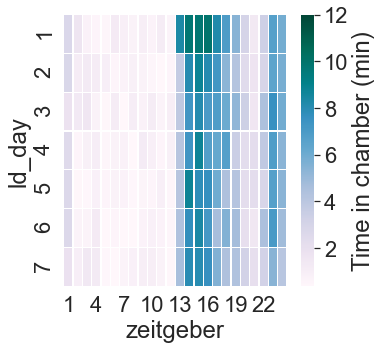

In [62]:
d = data_RFID_total_hour_day[data_RFID_total_hour_day['kmeans_cluster']=='cluster_2']
groupby = d.groupby(['ld_day', 'zeitgeber'])['Time in chamber (min)'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "Time in chamber (min)")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=12,
                     cbar_kws={'label': 'Time in chamber (min)'})

#plt.xlabel('Bottle')
plt.show()

## total with separate substances 

### event duration proportion

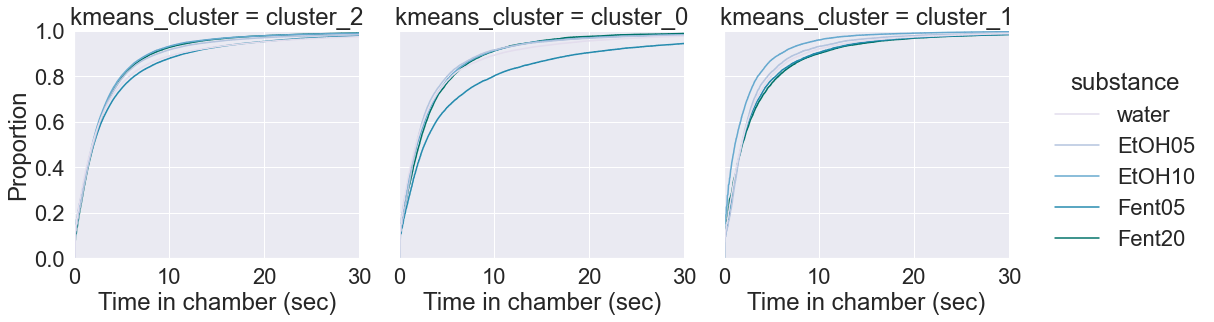

In [63]:

g=sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='substance', col='kmeans_cluster', 
              palette='PuBuGn', hue_order=drink_order, col_order=cluster_order)
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [64]:
data_RFID_total_sub = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 'substance',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_sub['Time in chamber (min)'] = data_RFID_total_sub['eventDuration']/60

data_RFID_total_sub.head()

,IdRFID,kmeans_cluster,substance,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,EtOH05,2413.942,40.232367
1,041ABFE4E6,cluster_2,EtOH10,3182.143,53.035717
2,041ABFE4E6,cluster_2,Fent05,2016.976,33.616267
3,041ABFE4E6,cluster_2,Fent20,1811.555,30.192583
4,041ABFE4E6,cluster_2,water,21709.277,361.821283


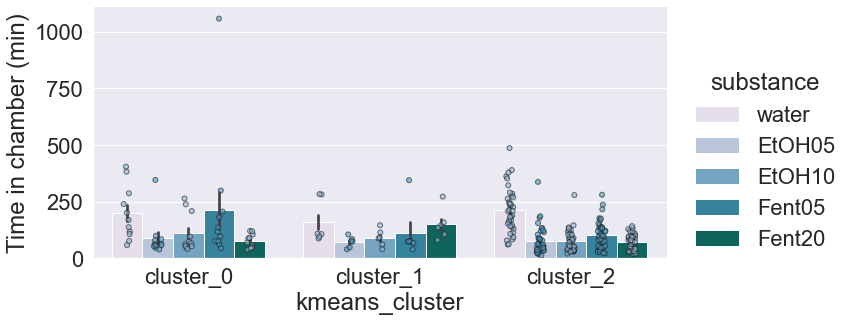

In [65]:
g= sns.catplot(x='kmeans_cluster', y='Time in chamber (min)', data=data_RFID_total_sub,  kind='bar', height=5, aspect=2,
            ci=68, hue='substance', hue_order=drink_order, order=cluster_order, palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'kmeans_cluster', 'Time in chamber (min)', 'substance',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1,
      hue_order=drink_order, order=cluster_order,)

#plt.xlabel('Cluster')
plt.show()

In [66]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='substance', between='kmeans_cluster', subject='IdRFID', data=data_RFID_total_sub)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='substance', between='kmeans_cluster',
                              subject='IdRFID', data=data_RFID_total_sub, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                  SS    DF1    DF2          MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
--------------  ----------  -----  -----  ----------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
kmeans_cluster   36984.440      2     53   18492.220   1.225    0.302      nan      0.044  nan           nan        nan        nan
substance       639832.559      4    212  159958.140  26.844    0.000        0.000  0.336    0.528         0.000      0.099      0.000
Interaction     125517.886      8    212   15689.736   2.633    0.009      nan      0.090  nan           nan        nan        nan


POST HOC TESTS

Contrast                    substance    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust               BF10    hedges
--------------------------  -----------  ---------  ---------  --------  ------------  ------  ------  ---------  -------  -----

## light dark with separate substances 

### event duration proportion

### total event duration sum

In [67]:
data_RFID_sub_ld = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 'ld_cycle', 'substance',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_sub_ld['Time in chamber (min)'] = data_RFID_sub_ld['eventDuration']/60

data_RFID_sub_ld.head()

,IdRFID,kmeans_cluster,ld_cycle,substance,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,dark,EtOH05,2142.355,35.705917
1,041ABFE4E6,cluster_2,dark,EtOH10,2725.643,45.427383
2,041ABFE4E6,cluster_2,dark,Fent05,1712.108,28.535133
3,041ABFE4E6,cluster_2,dark,Fent20,1592.380,26.539667
4,041ABFE4E6,cluster_2,dark,water,18601.822,310.030367


In [68]:
x = data_RFID_sub_ld[data_RFID_sub_ld['kmeans_cluster']=='cluster_1'].set_index(['kmeans_cluster', 'ld_cycle', 'IdRFID',  'substance', ]).unstack(-1).reset_index()
x.head()

kmeans_cluster ld_cycle      IdRFID eventDuration                                            Time in chamber (min)                                                
substance                                            EtOH05    EtOH10     Fent05     Fent20      water                EtOH05      EtOH10      Fent05      Fent20       water
0          cluster_1      dark     041AC15ECB  5989.605      6016.784  4048.328   4335.881   14977.324  99.826750             100.279733  67.472133   72.264683   249.622067
1          cluster_1      dark     041AC160C0  4532.230      4636.778  3687.197   6800.607   5383.759   75.537167             77.279633   61.453283   113.343450  89.729317 
2          cluster_1      dark     041AC16317  2110.268      2976.716  3840.543   6528.565   4423.086   35.171133             49.611933   64.009050   108.809417  73.718100 
3          cluster_1      dark     041AC16672  4356.917      8673.819  20314.940  16193.281  16827.028  72.615283             144.563650  338.582333  269.888017  280.450467
4          cluster_1      dark     041AC1667D  4337.561      2356.655  2323.058   6210.928   6420.287   72.292683             39.277583   38.717633   103.515467  107.004783

In [ ]:
x.to_csv('data_RFID_sub_ld_cluster1.csv')

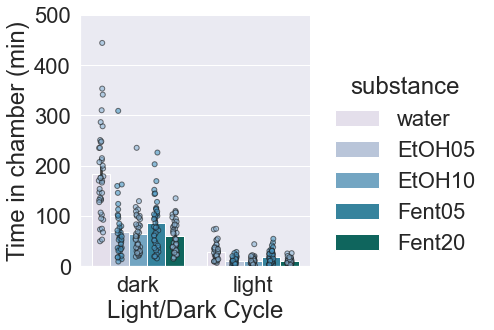

In [69]:
d = data_RFID_sub_ld[data_RFID_sub_ld['kmeans_cluster']=='cluster_2']

g= sns.catplot(x='ld_cycle', y='Time in chamber (min)', data=d,  kind='bar', height=5, aspect=1,
            ci=68, hue='substance', palette='PuBuGn', hue_order=drink_order)

# map data to stripplot
g.map(sns.stripplot, 'ld_cycle', 'Time in chamber (min)', 'substance', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', 
      linewidth=1, hue_order=drink_order)

plt.ylim(0,500)
plt.xlabel('Light/Dark Cycle')
plt.show()

In [70]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.rm_anova(dv=dv, within=['ld_cycle', 'substance'], subject='IdRFID', data=d)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within=['ld_cycle', 'substance'],
                              subject='IdRFID', data=d, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                        SS    ddof1    ddof2          MS        F    p-unc    p-GG-corr    np2    eps
--------------------  ----------  -------  -------  ----------  -------  -------  -----------  -----  -----
ld_cycle              571712.897        1       38  571712.897  192.314    0.000        0.000  0.835  1.000
substance             274574.141        4      152   68643.535   47.697    0.000        0.000  0.557  0.554
ld_cycle * substance  147309.102        4      152   36827.276   41.739    0.000        0.000  0.523  0.539


POST HOC TESTS

Contrast              ld_cycle    A       B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust                  BF10    hedges
--------------------  ----------  ------  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ------------------  --------
ld_cycle              -           dark    light   True      True          13.868  38.000  two-sided    0

## daily with separate substances

In [71]:
data_RFID_sub_daily = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 'ld_day', 'substance'
                                   ])['eventDuration'].sum().reset_index()

data_RFID_sub_daily['Time in chamber (min)'] = data_RFID_sub_daily['eventDuration']/60

data_RFID_sub_daily.head()

,IdRFID,kmeans_cluster,ld_day,substance,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,1,EtOH05,1158.326,19.305433
1,041ABFE4E6,cluster_2,1,EtOH10,946.228,15.770467
2,041ABFE4E6,cluster_2,1,Fent05,870.990,14.516500
3,041ABFE4E6,cluster_2,1,Fent20,572.351,9.539183
4,041ABFE4E6,cluster_2,1,water,2998.588,49.976467


In [72]:
data_RFID_sub_daily['Time in chamber (min)'].max()

190.0112166666667

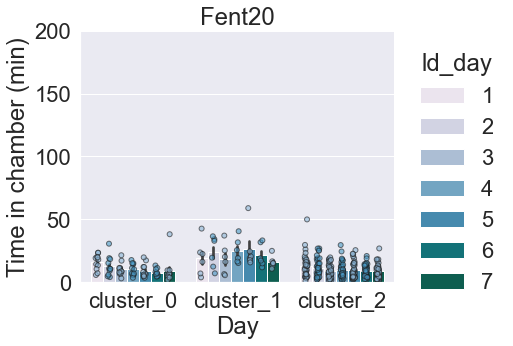

In [81]:
sub = 'Fent20'
d = data_RFID_sub_daily[data_RFID_sub_daily['substance']==sub]
order=['cluster_0', 'cluster_1', 'cluster_2']
g= sns.catplot(x='kmeans_cluster', y='Time in chamber (min)', data=d,  kind='bar', height=5, aspect=1.2,
            ci=68, hue='ld_day', palette='PuBuGn', order=order)

# map data to stripplot
g.map(sns.stripplot, 'kmeans_cluster', 'Time in chamber (min)', 'ld_day', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, order=order)

plt.ylim(0,200)
plt.title(sub)
plt.xlabel('Day')
plt.show()

In [82]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='kmeans_cluster', subject='IdRFID', data=d)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='kmeans_cluster',
                              subject='IdRFID', data=d, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                SS    DF1    DF2        MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
--------------  --------  -----  -----  --------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
kmeans_cluster  4760.119      2     53  2380.059  11.691    0.000      nan      0.306  nan           nan        nan        nan
ld_day           936.591      6    318   156.099   6.154    0.000        0.000  0.104    0.657         0.000      0.137      0.000
Interaction      620.838     12    318    51.736   2.040    0.021      nan      0.071  nan           nan        nan        nan


POST HOC TESTS

Contrast                 ld_day    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust        BF10    hedges
-----------------------  --------  ---------  ---------  --------  ------------  ------  ------  ---------  -------  --------  ----------  --------  --------
ld_

## daily and hourly total with separate substance heatmap

### event duration

In [83]:
data_RFID_total_sub_day_hour = data_RFID.groupby(['IdRFID', 'kmeans_cluster', 'substance', 'ld_day', 'zeitgeber',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_sub_day_hour['Time in chamber (min)'] = data_RFID_total_sub_day_hour['eventDuration']/60

data_RFID_total_sub_day_hour.head()

,IdRFID,kmeans_cluster,substance,ld_day,zeitgeber,eventDuration,Time in chamber (min)
0,041ABFE4E6,cluster_2,EtOH05,1,1,9.074,0.151233
1,041ABFE4E6,cluster_2,EtOH05,1,2,0.000,0.000000
2,041ABFE4E6,cluster_2,EtOH05,1,3,5.823,0.097050
3,041ABFE4E6,cluster_2,EtOH05,1,4,0.000,0.000000
4,041ABFE4E6,cluster_2,EtOH05,1,5,0.344,0.005733


In [84]:
data_RFID_total_sub_day_hour['substance'].unique()

array(['EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water'], dtype=object)

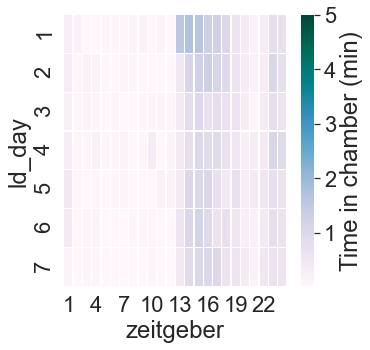

In [85]:
d = data_RFID_total_sub_day_hour[data_RFID_total_sub_day_hour['kmeans_cluster']=='cluster_2']
d = d[d['substance']=='Fent20']

groupby = d.groupby(['ld_day', 'zeitgeber'])['Time in chamber (min)'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "Time in chamber (min)")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=5,
                     cbar_kws={'label': 'Time in chamber (min)'})

#plt.xlabel('Bottle')
plt.show()

## ID heatmap

In [86]:
data_RFID_total_sub['Id'] = data_RFID_total_sub['kmeans_cluster'] + '_' + data_RFID_total_sub['IdRFID'].astype('str')
data_RFID_total_sub.head()

,IdRFID,kmeans_cluster,substance,eventDuration,Time in chamber (min),Id
0,041ABFE4E6,cluster_2,EtOH05,2413.942,40.232367,cluster_2_041ABFE4E6
1,041ABFE4E6,cluster_2,EtOH10,3182.143,53.035717,cluster_2_041ABFE4E6
2,041ABFE4E6,cluster_2,Fent05,2016.976,33.616267,cluster_2_041ABFE4E6
3,041ABFE4E6,cluster_2,Fent20,1811.555,30.192583,cluster_2_041ABFE4E6
4,041ABFE4E6,cluster_2,water,21709.277,361.821283,cluster_2_041ABFE4E6


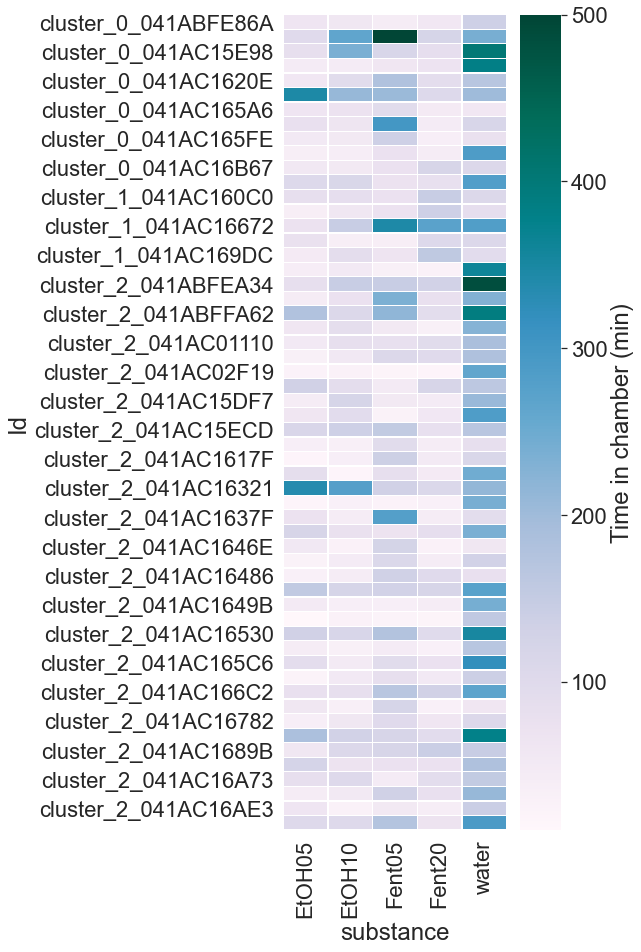

In [87]:
sns.set(font_scale=2)
groupby = data_RFID_total_sub.pivot('Id', 'substance', "Time in chamber (min)")
plt.figure(figsize=(5,15))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=500,
                     cbar_kws={'label': 'Time in chamber (min)'})

#plt.xlabel('Bottle')
plt.show()

# Project clusters back onto drinking data

In [88]:
sns.set_context("poster")
sns.set_style("ticks")
sns.set(font_scale=2)

In [89]:
data_final_clean_3s = data_final


In [90]:
data_final_clean_3s = data_behav_PCA[['IdRFID', 'kmeans_cluster']].merge(data_final_clean_3s, on='IdRFID')
data_VDM_start = data_behav_PCA[['IdRFID', 'kmeans_cluster']].merge(data_VDM_start, on='IdRFID')

data_final_clean_3s.head()

,IdRFID,kmeans_cluster,zeitgeber,ld_day,ddd,ld_cycle,substance,Sex,intake_ml_kg
0,041AC162AC,cluster_2,1,1,0,light,EtOH05,male,0.0
1,041AC162AC,cluster_2,2,1,0,light,EtOH05,male,0.0
2,041AC162AC,cluster_2,3,1,0,light,EtOH05,male,0.0
3,041AC162AC,cluster_2,4,1,0,light,EtOH05,male,0.0
4,041AC162AC,cluster_2,5,1,0,light,EtOH05,male,0.0


## total with combined substances

### total intake sum min

In [91]:
data_VDM_total_min = data_VDM_start.groupby(['IdRFID', 'kmeans_cluster', 'VDM_min_count_running',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_min.head()

,IdRFID,kmeans_cluster,VDM_min_count_running,intake_ml_kg
0,041ABFE4E6,cluster_2,-218,2.491349
1,041ABFE4E6,cluster_2,-214,3.321799
2,041ABFE4E6,cluster_2,-207,2.491349
3,041ABFE4E6,cluster_2,-169,0.830450
4,041ABFE4E6,cluster_2,-143,3.321799


(0.0, 10.0)

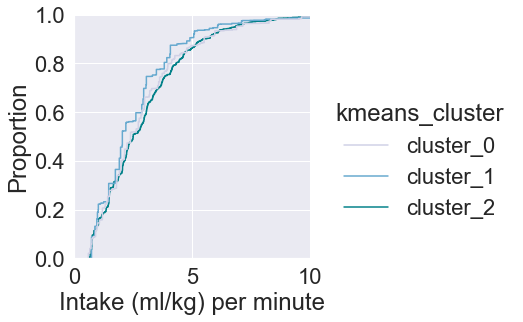

In [92]:
sns.displot(data=data_VDM_total_min, x="intake_ml_kg", kind='ecdf', hue='kmeans_cluster',
           palette='PuBuGn', hue_order=cluster_order)

plt.xlabel('Intake (ml/kg) per minute')

plt.xlim(0,10)

### total intake sum

In [93]:
data_VDM_total = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total.head()

,IdRFID,kmeans_cluster,intake_ml_kg
0,041ABFE4E6,cluster_2,1315.086505
1,041ABFE86A,cluster_0,540.588235
2,041ABFEA34,cluster_2,726.562500
3,041ABFEE18,cluster_2,792.178218
4,041ABFFA62,cluster_2,989.333333


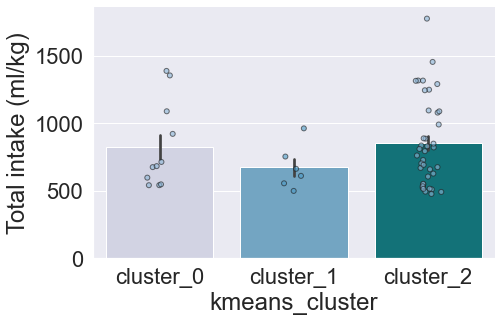

F_onewayResult(statistic=0.8454262084821482, pvalue=0.43508208015600336)


In [94]:
g = sns.catplot(x='kmeans_cluster', y='intake_ml_kg', data=data_VDM_total,  kind='bar', height=5, aspect=1.5,
            ci=68, palette='PuBuGn', order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'kmeans_cluster', 'intake_ml_kg', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, order=cluster_order)
plt.ylabel('Total intake (ml/kg)')
plt.show()

param = 'intake_ml_kg'
a=data_VDM_total[data_VDM_total['kmeans_cluster']=='cluster_0'][param].values
b=data_VDM_total[data_VDM_total['kmeans_cluster']=='cluster_1'][param].values
c=data_VDM_total[data_VDM_total['kmeans_cluster']=='cluster_2'][param].values
print(f_oneway(a, b, c))

## light dark with combined substances

### total intake sum min

In [95]:
data_VDM_total_ld_min = data_VDM_start.groupby(['IdRFID', 'kmeans_cluster', 'VDM_min_count_running', 'ld_cycle',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_ld_min.head()

,IdRFID,kmeans_cluster,VDM_min_count_running,ld_cycle,intake_ml_kg
0,041ABFE4E6,cluster_2,-218,dark,2.491349
1,041ABFE4E6,cluster_2,-214,dark,3.321799
2,041ABFE4E6,cluster_2,-207,dark,2.491349
3,041ABFE4E6,cluster_2,-169,dark,0.830450
4,041ABFE4E6,cluster_2,-143,dark,3.321799


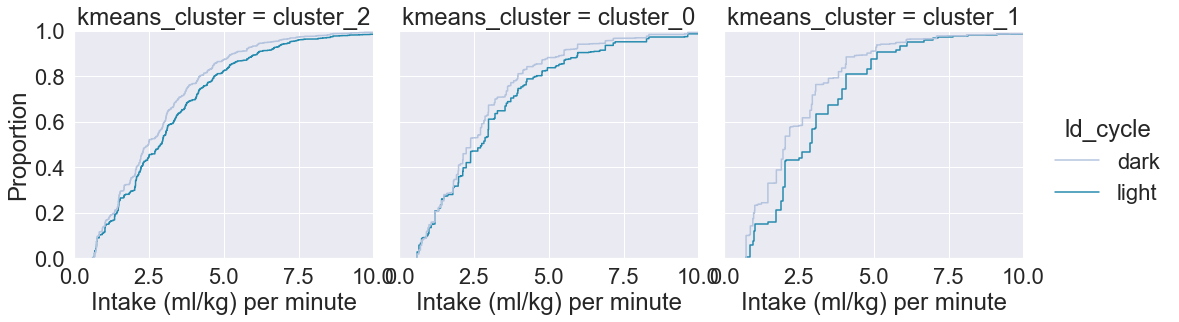

In [96]:
g=sns.displot(data=data_VDM_total_ld_min, x="intake_ml_kg", kind='ecdf', hue='ld_cycle', col='kmeans_cluster', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,10)

g.set_axis_labels('Intake (ml/kg) per minute')
plt.show()

### total intake sum

In [97]:
data_VDM_total_ld = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 'ld_cycle',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_ld.head()

,IdRFID,kmeans_cluster,ld_cycle,intake_ml_kg
0,041ABFE4E6,cluster_2,dark,970.242215
1,041ABFE4E6,cluster_2,light,344.844291
2,041ABFE86A,cluster_0,dark,451.544118
3,041ABFE86A,cluster_0,light,89.044118
4,041ABFEA34,cluster_2,dark,592.500000


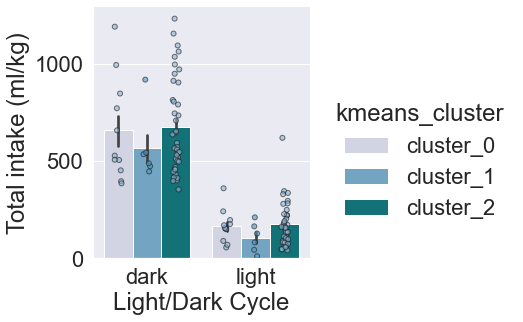

In [98]:
g= sns.catplot(x='ld_cycle', y='intake_ml_kg', data=data_VDM_total_ld,  kind='bar', height=5, aspect=1,
            ci=68, hue='kmeans_cluster', palette='PuBuGn', hue_order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'ld_cycle', 'intake_ml_kg', 'kmeans_cluster',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, hue_order=cluster_order)


plt.xlabel('Light/Dark Cycle')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [99]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_cycle', between='kmeans_cluster', subject='IdRFID', data=data_VDM_total_ld)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_cycle', between='kmeans_cluster',
                              subject='IdRFID', data=data_VDM_total_ld, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                   SS    DF1    DF2           MS        F    p-unc    np2      eps
--------------  -----------  -----  -----  -----------  -------  -------  -----  -------
kmeans_cluster    81848.320      2     53    40924.160    0.845    0.435  0.031  nan
ld_cycle        6863250.025      1     53  6863250.025  318.411    0.000  0.857    1.000
Interaction        4238.886      2     53     2119.443    0.098    0.907  0.004  nan


POST HOC TESTS

Contrast                   ld_cycle    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust                          BF10    hedges
-------------------------  ----------  ---------  ---------  --------  ------------  ------  ------  ---------  -------  --------  ----------  --------------------------  --------
ld_cycle                   -           dark       light      True      True          18.144  55.000  two-sided    0.000   nan      nan         5244000000000000000000.000

## daily total combine substances

### total intake sum min

In [100]:
data_VDM_total_daily_min = data_VDM_start.groupby(['IdRFID', 'kmeans_cluster', 'VDM_min_count_running', 'ld_day',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_daily_min.head()

,IdRFID,kmeans_cluster,VDM_min_count_running,ld_day,intake_ml_kg
0,041ABFE4E6,cluster_2,-218,1,2.491349
1,041ABFE4E6,cluster_2,-214,1,3.321799
2,041ABFE4E6,cluster_2,-207,1,2.491349
3,041ABFE4E6,cluster_2,-169,1,0.830450
4,041ABFE4E6,cluster_2,-143,1,3.321799


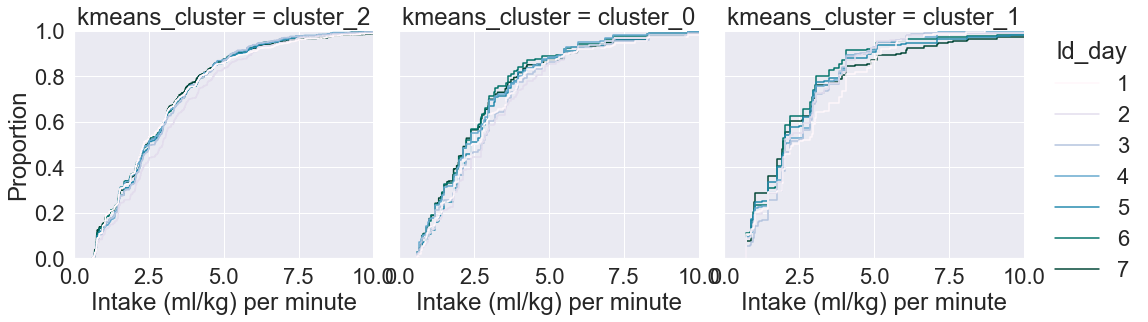

In [101]:
g=sns.displot(data=data_VDM_total_daily_min, x="intake_ml_kg", kind='ecdf', hue='ld_day', col='kmeans_cluster', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,10)

g.set_axis_labels('Intake (ml/kg) per minute')
plt.show()

### total intake sum

In [102]:
data_VDM_total_daily = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 'ld_day',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_daily.head()

,IdRFID,kmeans_cluster,ld_day,intake_ml_kg
0,041ABFE4E6,cluster_2,1,123.114187
1,041ABFE4E6,cluster_2,2,216.055363
2,041ABFE4E6,cluster_2,3,213.425606
3,041ABFE4E6,cluster_2,4,176.055363
4,041ABFE4E6,cluster_2,5,179.515571


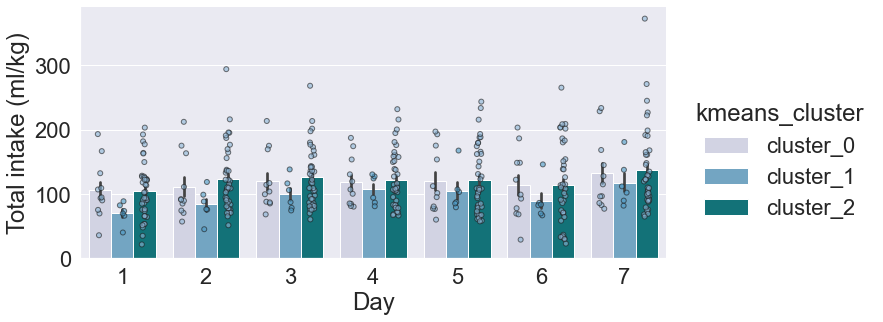

In [103]:
g= sns.catplot(x='ld_day', y='intake_ml_kg', data=data_VDM_total_daily,  kind='bar', height=5, aspect=2,
            ci=68, hue='kmeans_cluster', palette='PuBuGn', hue_order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'ld_day', 'intake_ml_kg', 'kmeans_cluster',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, hue_order=cluster_order)

plt.xlabel('Day')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [104]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='kmeans_cluster', subject='IdRFID', data=data_VDM_total_daily)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='kmeans_cluster',
                              subject='IdRFID', data=data_VDM_total_daily, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                 SS    DF1    DF2         MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
--------------  ---------  -----  -----  ---------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
kmeans_cluster  23385.234      2     53  11692.617  0.845    0.435      nan      0.031  nan           nan        nan        nan
ld_day          33311.587      6    318   5551.931  8.772    0.000        0.000  0.142    0.473         0.000      0.035      0.000
Interaction      3289.554     12    318    274.129  0.433    0.950      nan      0.016  nan           nan        nan        nan


POST HOC TESTS

Contrast                 ld_day    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust        BF10    hedges
-----------------------  --------  ---------  ---------  --------  ------------  ------  ------  ---------  -------  --------  ----------  --------  -------

## hourly total with combined substances

### total intake sum

In [105]:
data_VDM_total_hourly = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 'zeitgeber',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_hourly.head()

,IdRFID,kmeans_cluster,zeitgeber,intake_ml_kg
0,041ABFE4E6,cluster_2,1,59.792388
1,041ABFE4E6,cluster_2,2,41.522491
2,041ABFE4E6,cluster_2,3,34.878893
3,041ABFE4E6,cluster_2,4,9.134948
4,041ABFE4E6,cluster_2,5,58.131488


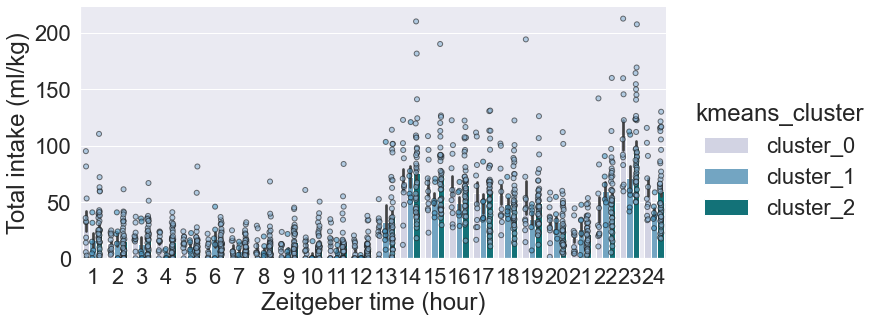

In [106]:
g= sns.catplot(x='zeitgeber', y='intake_ml_kg', data=data_VDM_total_hourly,  kind='bar', height=5, aspect=2,
            ci=68, hue='kmeans_cluster', palette='PuBuGn', hue_order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'zeitgeber', 'intake_ml_kg', 'kmeans_cluster',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, hue_order=cluster_order)

plt.xlabel('Zeitgeber time (hour)')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [107]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='zeitgeber', between='kmeans_cluster', subject='IdRFID', data=data_VDM_total_hourly)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='zeitgeber', between='kmeans_cluster',
                              subject='IdRFID', data=data_VDM_total_hourly, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                  SS    DF1    DF2         MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
--------------  ----------  -----  -----  ---------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
kmeans_cluster    6820.693      2     53   3410.347   0.845    0.435      nan      0.031  nan           nan        nan        nan
zeitgeber       850274.321     23   1219  36968.449  97.191    0.000        0.000  0.647    0.292         0.000      0.000      0.000
Interaction      15717.590     46   1219    341.687   0.898    0.666      nan      0.033  nan           nan        nan        nan


POST HOC TESTS

Contrast                    zeitgeber    A          B          Paired    Parametric          T     dof  Tail         p-unc    p-corr  p-adjust                         BF10    hedges
--------------------------  -----------  ---------  ---------  --------  ------------  -------  ------  ---------  -------

## daily and hourly combines substances heatmap

### total drinking

In [108]:
data_VDM_total_hour_day = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 'zeitgeber', 'ld_day',
                                   ])['intake_ml_kg'].sum().reset_index()

data_VDM_total_hour_day.head()

,IdRFID,kmeans_cluster,zeitgeber,ld_day,intake_ml_kg
0,041ABFE4E6,cluster_2,1,1,7.474048
1,041ABFE4E6,cluster_2,1,2,22.422145
2,041ABFE4E6,cluster_2,1,3,0.000000
3,041ABFE4E6,cluster_2,1,4,10.795848
4,041ABFE4E6,cluster_2,1,5,9.134948


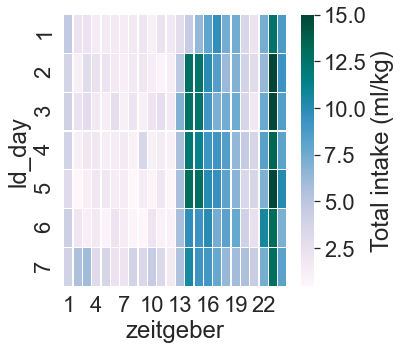

In [109]:
d = data_VDM_total_hour_day[data_VDM_total_hour_day['kmeans_cluster']=='cluster_2']
groupby = d.groupby(['ld_day', 'zeitgeber'])['intake_ml_kg'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "intake_ml_kg")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=15,
                     cbar_kws={'label': 'Total intake (ml/kg)'})

#plt.xlabel('Bottle')
plt.show()

## total with separate substances

### total intake sum min

In [110]:
data_VDM_total_sub_min = data_VDM_start.groupby(['IdRFID', 'kmeans_cluster', 'VDM_min_count_running', 'substance',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub_min.head()

,IdRFID,kmeans_cluster,VDM_min_count_running,substance,intake_ml_kg
0,041ABFE4E6,cluster_2,-218,water,2.491349
1,041ABFE4E6,cluster_2,-214,water,3.321799
2,041ABFE4E6,cluster_2,-207,water,2.491349
3,041ABFE4E6,cluster_2,-169,water,0.830450
4,041ABFE4E6,cluster_2,-143,water,3.321799


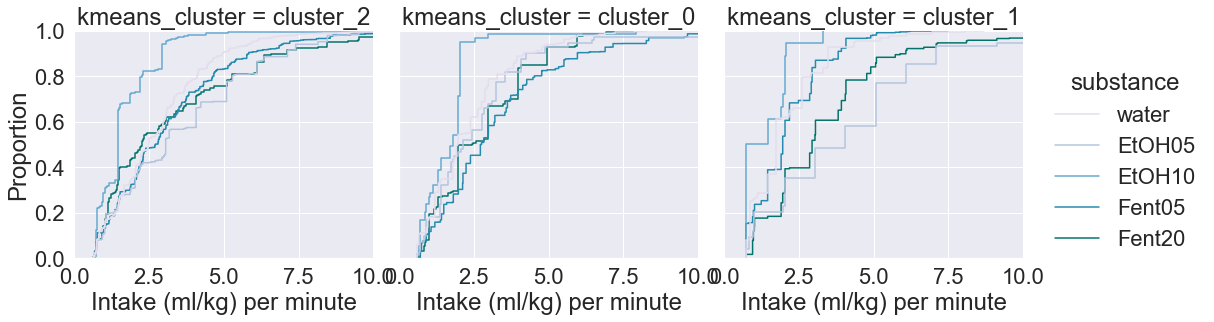

In [111]:
g=sns.displot(data=data_VDM_total_sub_min, x="intake_ml_kg", kind='ecdf', hue='substance', col='kmeans_cluster', 
              hue_order=drink_order, col_order=cluster_order, palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,10)

g.set_axis_labels('Intake (ml/kg) per minute')
plt.show()

### total intake sum

In [112]:
data_VDM_total_sub = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 'substance',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub.tail()

,IdRFID,kmeans_cluster,substance,intake_ml_kg
275,041AC16B67,cluster_0,EtOH05,5.943396
276,041AC16B67,cluster_0,EtOH10,31.698113
277,041AC16B67,cluster_0,Fent05,229.811321
278,041AC16B67,cluster_0,Fent20,407.122642
279,041AC16B67,cluster_0,water,6.933962


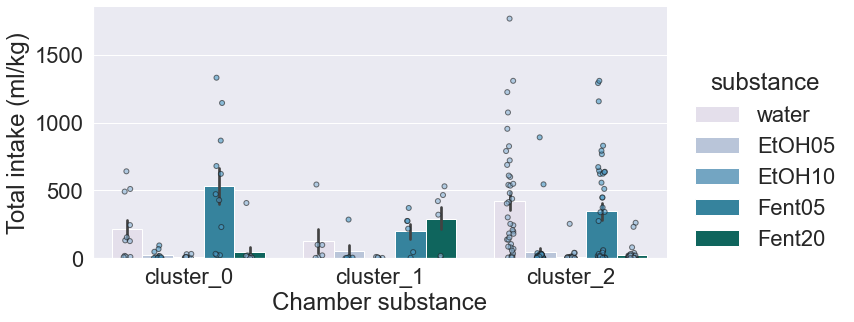

In [113]:
g= sns.catplot(x='kmeans_cluster', y='intake_ml_kg', data=data_VDM_total_sub,  kind='bar', height=5, aspect=2,
            ci=68, hue='substance', hue_order=drink_order, order=cluster_order, palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'kmeans_cluster', 'intake_ml_kg', 'substance',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1,
      hue_order=drink_order, order=cluster_order,)

plt.xlabel('Chamber substance')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [114]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='substance', between='kmeans_cluster', subject='IdRFID', data=data_VDM_total_sub)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='substance', between='kmeans_cluster',
                              subject='IdRFID', data=data_VDM_total_sub, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                   SS    DF1    DF2           MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
--------------  -----------  -----  -----  -----------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
kmeans_cluster    32739.328      2     53    16369.664   0.845    0.435      nan      0.031  nan           nan        nan        nan
substance       7050249.528      4    212  1762562.382  23.470    0.000        0.000  0.307    0.422         0.000      0.021      0.000
Interaction     1533507.571      8    212   191688.446   2.552    0.011      nan      0.088  nan           nan        nan        nan


POST HOC TESTS

Contrast                    substance    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust           BF10    hedges
--------------------------  -----------  ---------  ---------  --------  ------------  ------  ------  ---------  ------- 

## light dark with separate substances 

### total intake

In [115]:
data_VDM_total_sub_ld = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 'ld_cycle', 'substance',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub_ld.head()

,IdRFID,kmeans_cluster,ld_cycle,substance,intake_ml_kg
0,041ABFE4E6,cluster_2,dark,EtOH05,0.761246
1,041ABFE4E6,cluster_2,dark,EtOH10,1.660900
2,041ABFE4E6,cluster_2,dark,Fent05,2.802768
3,041ABFE4E6,cluster_2,dark,Fent20,0.000000
4,041ABFE4E6,cluster_2,dark,water,965.017301


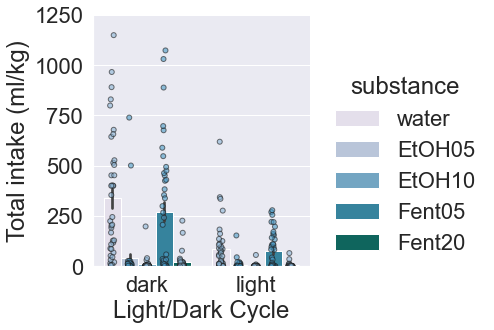

In [116]:
d = data_VDM_total_sub_ld[data_VDM_total_sub_ld['kmeans_cluster']=='cluster_2']

g= sns.catplot(x='ld_cycle', y='intake_ml_kg', data=d,  kind='bar', height=5, aspect=1,
            ci=68, hue='substance', palette='PuBuGn', hue_order=drink_order,)

# map data to stripplot
g.map(sns.stripplot, 'ld_cycle', 'intake_ml_kg', 'substance', hue_order=drink_order,
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', 
      linewidth=1)

plt.ylim(0,1250)
plt.xlabel('Light/Dark Cycle')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [117]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.rm_anova(dv=dv, within=['ld_cycle', 'substance'], subject='IdRFID', data=d)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within=['ld_cycle', 'substance'],
                              subject='IdRFID', data=d, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                         SS    ddof1    ddof2          MS        F    p-unc    p-GG-corr    np2    eps
--------------------  -----------  -------  -------  ----------  -------  -------  -----------  -----  -----
ld_cycle               979245.732        1       38  979245.732  240.912    0.000        0.000  0.864  1.000
substance             3053444.254        4      152  763361.064   18.150    0.000        0.000  0.323  0.384
ld_cycle * substance  1037273.992        4      152  259318.498   19.716    0.000        0.000  0.342  0.406


POST HOC TESTS

Contrast              ld_cycle    A       B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust                    BF10    hedges
--------------------  ----------  ------  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  --------------------  --------
ld_cycle              -           dark    light   True      True          15.521  38.000  two-s

## daily with separate substances

In [118]:
data_VDM_total_sub_day = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 'ld_day', 'substance',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub_day.head()

,IdRFID,kmeans_cluster,ld_day,substance,intake_ml_kg
0,041ABFE4E6,cluster_2,1,EtOH05,0.000000
1,041ABFE4E6,cluster_2,1,EtOH10,0.000000
2,041ABFE4E6,cluster_2,1,Fent05,1.868512
3,041ABFE4E6,cluster_2,1,Fent20,0.000000
4,041ABFE4E6,cluster_2,1,water,121.245675


In [119]:
data_VDM_total_sub_day['intake_ml_kg'].max()

372.6234567901234

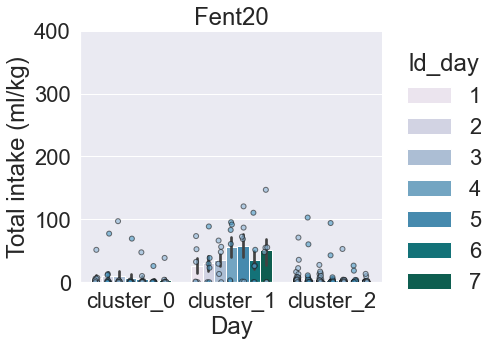

In [128]:
sub = 'Fent20'
d = data_VDM_total_sub_day[data_VDM_total_sub_day['substance']==sub]
order=['cluster_0', 'cluster_1', 'cluster_2']
g= sns.catplot(x='kmeans_cluster', y='intake_ml_kg', data=d,  kind='bar', height=5, aspect=1.2,
            ci=68, hue='ld_day', palette='PuBuGn', order=order)

# map data to stripplot
g.map(sns.stripplot, 'kmeans_cluster', 'intake_ml_kg', 'ld_day', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, order=order)

plt.ylim(0,400)
plt.title(sub)
plt.xlabel('Day')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [129]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='kmeans_cluster', subject='IdRFID', data=d)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='kmeans_cluster',
                              subject='IdRFID', data=d, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                 SS    DF1    DF2         MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
--------------  ---------  -----  -----  ---------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
kmeans_cluster  54387.071      2     53  27193.536  19.285    0.000      nan      0.421  nan           nan        nan        nan
ld_day            830.316      6    318    138.386   1.040    0.399        0.422  0.019    0.475         0.000      0.005      0.000
Interaction      6582.395     12    318    548.533   4.123    0.000      nan      0.135  nan           nan        nan        nan


POST HOC TESTS

Contrast                 ld_day    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
-----------------------  --------  ---------  ---------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ------  ------

## daily and hourly total with separate substances heatmap

### total intake

In [130]:
data_VDM_total_sub_day_hour = data_final_clean_3s.groupby(['IdRFID', 'kmeans_cluster', 'substance', 'ld_day', 'zeitgeber',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub_day_hour.head()

,IdRFID,kmeans_cluster,substance,ld_day,zeitgeber,intake_ml_kg
0,041ABFE4E6,cluster_2,EtOH05,1,1,0.0
1,041ABFE4E6,cluster_2,EtOH05,1,2,0.0
2,041ABFE4E6,cluster_2,EtOH05,1,3,0.0
3,041ABFE4E6,cluster_2,EtOH05,1,4,0.0
4,041ABFE4E6,cluster_2,EtOH05,1,5,0.0


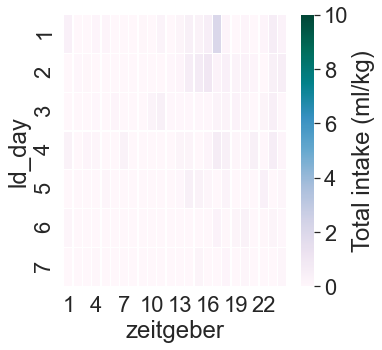

In [131]:
d = data_VDM_total_sub_day_hour[data_VDM_total_sub_day_hour['kmeans_cluster']=='cluster_2']
d = d[d['substance']=='Fent20']
groupby = d.groupby(['ld_day', 'zeitgeber'])['intake_ml_kg'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "intake_ml_kg")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=10,
                     cbar_kws={'label': 'Total intake (ml/kg)'})

#plt.xlabel('Bottle')
plt.show()

## preference

#### total by substance

In [132]:
data_summary_vol = data_VDM_total_sub.set_index(['IdRFID', 'kmeans_cluster', 
                                  'substance'])[['intake_ml_kg']].unstack(-1).reset_index()

data_summary_vol.columns = ['IdRFID', 'kmeans_cluster', 
                        'EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water',]

data_summary_vol.replace(np.nan, 0, inplace=True)

data_summary_vol['total_alcohol_intake'] = data_summary_vol['EtOH05'] + data_summary_vol['EtOH10'] 
data_summary_vol['total_fent_intake'] = data_summary_vol['Fent05'] + data_summary_vol['Fent20'] 

data_summary_vol['overall_alcohol_pref'] = data_summary_vol['total_alcohol_intake'] / (data_summary_vol['total_alcohol_intake'] + data_summary_vol['water'])
data_summary_vol['overall_fent_pref'] = data_summary_vol['total_fent_intake'] / (data_summary_vol['total_fent_intake'] + data_summary_vol['water'])

data_summary_vol['DP_alcohol'] =  ((data_summary_vol['EtOH05']*.05) + (data_summary_vol['EtOH10']*.1))  \
/ (data_summary_vol['EtOH05'] + data_summary_vol['EtOH10'])

data_summary_vol['DP_fent'] =  ((data_summary_vol['Fent05']*.05) + (data_summary_vol['Fent20']*.2))  \
/ (data_summary_vol['Fent05'] + data_summary_vol['Fent20'])
data_summary_vol.replace(np.nan, 0, inplace=True)
data_summary_vol.head()

,IdRFID,kmeans_cluster,EtOH05,EtOH10,Fent05,Fent20,water,total_alcohol_intake,total_fent_intake,overall_alcohol_pref,overall_fent_pref,DP_alcohol,DP_fent
0,041ABFE4E6,cluster_2,0.761246,1.660900,4.671280,0.000000,1307.993080,2.422145,4.671280,0.001848,0.003559,0.084286,0.050000
1,041ABFE86A,cluster_0,5.147059,0.992647,21.985294,21.176471,491.286765,6.139706,43.161765,0.012343,0.080759,0.058084,0.123595
2,041ABFEA34,cluster_2,10.312500,16.875000,556.875000,38.437500,104.062500,27.187500,595.312500,0.207143,0.851206,0.081034,0.059685
3,041ABFEE18,cluster_2,4.158416,2.079208,767.227723,4.158416,14.554455,6.237624,771.386139,0.300000,0.981481,0.066667,0.050809
4,041ABFFA62,cluster_2,2.333333,0.000000,829.500000,19.833333,137.666667,2.333333,849.333333,0.016667,0.860520,0.050000,0.053503


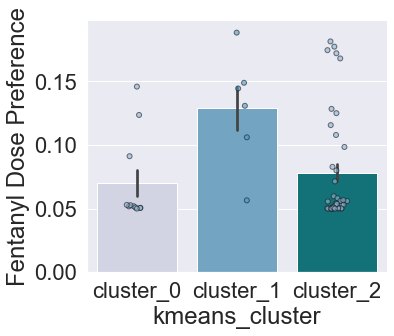

F_onewayResult(statistic=4.392500005562109, pvalue=0.01717551193419184)


In [133]:
g = sns.catplot(x='kmeans_cluster', y='DP_fent', data=data_summary_vol,  kind='bar', height=5, aspect=1.2,
            ci=68, palette='PuBuGn', order=cluster_order)

# map data to stripplot
g.map(sns.stripplot, 'kmeans_cluster', 'DP_fent', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1, order=cluster_order)
plt.ylabel('Fentanyl Dose Preference')
plt.show()

param = 'DP_fent'
a=data_summary_vol[data_summary_vol['kmeans_cluster']=='cluster_0'][param].values
b=data_summary_vol[data_summary_vol['kmeans_cluster']=='cluster_1'][param].values
c=data_summary_vol[data_summary_vol['kmeans_cluster']=='cluster_2'][param].values
print(f_oneway(a, b, c))

#### daily by substance

In [134]:
data_summary_vol_day = data_VDM_total_sub_day.set_index(['IdRFID', 'kmeans_cluster', 'ld_day', 
                                  'substance'])[['intake_ml_kg']].unstack(-1).reset_index()

data_summary_vol_day.columns = ['IdRFID', 'kmeans_cluster', 'ld_day', 
                        'EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water',]

data_summary_vol_day.replace(np.nan, 0, inplace=True)

data_summary_vol_day['total_alcohol_intake'] = data_summary_vol_day['EtOH05'] + data_summary_vol_day['EtOH10'] 
data_summary_vol_day['total_fent_intake'] = data_summary_vol_day['Fent05'] + data_summary_vol_day['Fent20'] 

data_summary_vol_day['overall_alcohol_pref'] = data_summary_vol_day['total_alcohol_intake'] / (data_summary_vol_day['total_alcohol_intake'] + data_summary_vol_day['water'])
data_summary_vol_day['overall_fent_pref'] = data_summary_vol_day['total_fent_intake'] / (data_summary_vol_day['total_fent_intake'] + data_summary_vol_day['water'])

data_summary_vol_day['DP_alcohol'] =  ((data_summary_vol_day['EtOH05']*.05) + (data_summary_vol_day['EtOH10']*.1))  \
/ (data_summary_vol_day['EtOH05'] + data_summary_vol_day['EtOH10'])

data_summary_vol_day['DP_fent'] =  ((data_summary_vol_day['Fent05']*.05) + (data_summary_vol_day['Fent20']*.2))  \
/ (data_summary_vol_day['Fent05'] + data_summary_vol_day['Fent20'])

data_summary_vol_day.replace(np.nan, 0, inplace=True)
data_summary_vol_day.head()

,IdRFID,kmeans_cluster,ld_day,EtOH05,EtOH10,Fent05,Fent20,water,total_alcohol_intake,total_fent_intake,overall_alcohol_pref,overall_fent_pref,DP_alcohol,DP_fent
0,041ABFE4E6,cluster_2,1,0.000000,0.00000,1.868512,0.0,121.245675,0.000000,1.868512,0.000000,0.015177,0.00,0.05
1,041ABFE4E6,cluster_2,2,0.761246,0.00000,1.868512,0.0,213.425606,0.761246,1.868512,0.003554,0.008679,0.05,0.05
2,041ABFE4E6,cluster_2,3,0.000000,0.00000,0.000000,0.0,213.425606,0.000000,0.000000,0.000000,0.000000,0.00,0.00
3,041ABFE4E6,cluster_2,4,0.000000,0.83045,0.000000,0.0,175.224913,0.830450,0.000000,0.004717,0.000000,0.10,0.00
4,041ABFE4E6,cluster_2,5,0.000000,0.83045,0.934256,0.0,177.750865,0.830450,0.934256,0.004650,0.005229,0.10,0.05


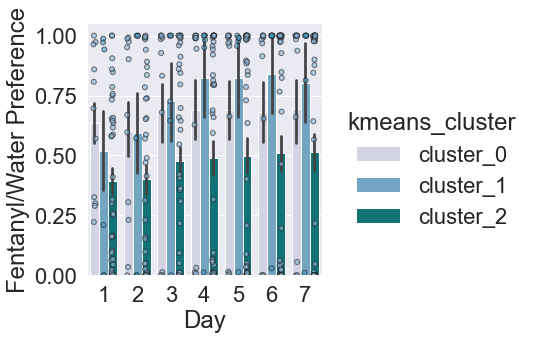

In [135]:
g= sns.catplot(x='ld_day', y='overall_fent_pref', data=data_summary_vol_day,  kind='bar', height=5, aspect=1,
            ci=68, hue='kmeans_cluster', palette='PuBuGn', hue_order=cluster_order)

# map data to DP_fent
g.map(sns.stripplot, 'ld_day', 'overall_fent_pref', 'kmeans_cluster', hue_order=cluster_order,
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)

#plt.ylim(0,1250)
plt.xlabel('Day')
plt.ylabel('Fentanyl/Water Preference')
plt.show()

In [136]:
dv = 'DP_fent'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='kmeans_cluster', subject='IdRFID', data=data_summary_vol_day)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='kmeans_cluster',
                              subject='IdRFID', data=data_summary_vol_day, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source             SS    DF1    DF2     MS      F    p-unc    np2      eps
--------------  -----  -----  -----  -----  -----  -------  -----  -------
kmeans_cluster  0.122      2     53  0.061  5.592    0.006  0.174  nan
ld_day          0.028      6    318  0.005  2.782    0.012  0.050    0.746
Interaction     0.036     12    318  0.003  1.742    0.057  0.062  nan


POST HOC TESTS

Contrast                 ld_day    A          B          Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
-----------------------  --------  ---------  ---------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ------  --------
ld_day                   -         1          2          True      True           1.116  55.000  two-sided    0.269     0.427  fdr_bh       0.263     0.150
ld_day                   -         1          3          True      True           1.476  55.000  two-sided    0.146     0.340  fdr_

#### daily and hourly total by substance

In [137]:
data_summary_vol_day = data_VDM_total_sub_day_hour.set_index(['IdRFID', 'kmeans_cluster', 'ld_day', 'zeitgeber',
                                  'substance'])[['intake_ml_kg']].unstack(-1).reset_index()

data_summary_vol_day.columns = ['IdRFID', 'kmeans_cluster', 'ld_day', 'zeitgeber',
                        'EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water',]

data_summary_vol_day.replace(np.nan, 0, inplace=True)

data_summary_vol_day['total_alcohol_intake'] = data_summary_vol_day['EtOH05'] + data_summary_vol_day['EtOH10'] 
data_summary_vol_day['total_fent_intake'] = data_summary_vol_day['Fent05'] + data_summary_vol_day['Fent20'] 

data_summary_vol_day['overall_alcohol_pref'] = data_summary_vol_day['total_alcohol_intake'] / (data_summary_vol_day['total_alcohol_intake'] + data_summary_vol_day['water'])
data_summary_vol_day['overall_fent_pref'] = data_summary_vol_day['total_fent_intake'] / (data_summary_vol_day['total_fent_intake'] + data_summary_vol_day['water'])

data_summary_vol_day['DP_alcohol'] =  ((data_summary_vol_day['EtOH05']*.05) + (data_summary_vol_day['EtOH10']*.1))  \
/ (data_summary_vol_day['EtOH05'] + data_summary_vol_day['EtOH10'])

data_summary_vol_day['DP_fent'] =  ((data_summary_vol_day['Fent05']*.05) + (data_summary_vol_day['Fent20']*.2))  \
/ (data_summary_vol_day['Fent05'] + data_summary_vol_day['Fent20'])

data_summary_vol_day.replace(np.nan, 0, inplace=True)
data_summary_vol_day.head()

,IdRFID,kmeans_cluster,ld_day,zeitgeber,EtOH05,EtOH10,Fent05,Fent20,water,total_alcohol_intake,total_fent_intake,overall_alcohol_pref,overall_fent_pref,DP_alcohol,DP_fent
0,041ABFE4E6,cluster_2,1,1,0.0,0.0,0.0,0.0,7.474048,0.0,0.0,0.0,0.0,0.0,0.0
1,041ABFE4E6,cluster_2,1,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,041ABFE4E6,cluster_2,1,3,0.0,0.0,0.0,0.0,5.813149,0.0,0.0,0.0,0.0,0.0,0.0
3,041ABFE4E6,cluster_2,1,4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,041ABFE4E6,cluster_2,1,5,0.0,0.0,0.0,0.0,11.626298,0.0,0.0,0.0,0.0,0.0,0.0


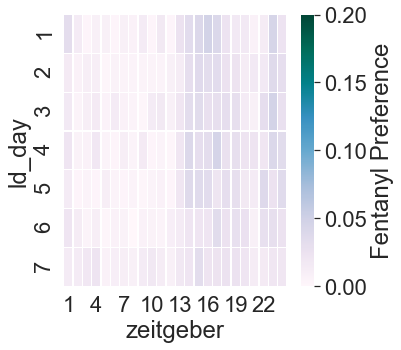

In [138]:
d = data_summary_vol_day[data_summary_vol_day['kmeans_cluster']=='cluster_2']

groupby = d.groupby(['ld_day', 'zeitgeber'])['DP_fent'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "DP_fent")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=.2,
                     cbar_kws={'label': 'Fentanyl Preference'})

#plt.xlabel('Bottle')
plt.show()

In [139]:
dv = 'overall_alcohol_pref'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='kmeans_cluster', subject='IdRFID', data=data_summary_vol_day)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='kmeans_cluster',
                              subject='IdRFID', data=data_summary_vol_day, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source             SS    DF1    DF2     MS      F    p-unc    np2      eps
--------------  -----  -----  -----  -----  -----  -------  -----  -------
kmeans_cluster  0.006      2     53  0.003  0.072    0.930  0.003  nan
ld_day          0.136      6    318  0.023  9.894    0.000  0.157    0.450
Interaction     0.057     12    318  0.005  2.065    0.019  0.072  nan


POST HOC TESTS

Contrast                 ld_day    A          B          Paired    Parametric         T       dof  Tail         p-unc    p-corr  p-adjust                BF10    hedges
-----------------------  --------  ---------  ---------  --------  ------------  ------  --------  ---------  -------  --------  ----------  ----------------  --------
ld_day                   -         1          2          True      True           5.688  1343.000  two-sided    0.000     0.000  holm              259300.000     0.210
ld_day                   -         1          3          True      True           7.839  1343.0

## ID heatmap

In [141]:
data_VDM_total_sub['Id'] = data_VDM_total_sub['kmeans_cluster'] + '_' + data_VDM_total_sub['IdRFID'].astype('str')
data_VDM_total_sub.head()

,IdRFID,kmeans_cluster,substance,intake_ml_kg,Id
0,041ABFE4E6,cluster_2,EtOH05,0.761246,cluster_2_041ABFE4E6
1,041ABFE4E6,cluster_2,EtOH10,1.660900,cluster_2_041ABFE4E6
2,041ABFE4E6,cluster_2,Fent05,4.671280,cluster_2_041ABFE4E6
3,041ABFE4E6,cluster_2,Fent20,0.000000,cluster_2_041ABFE4E6
4,041ABFE4E6,cluster_2,water,1307.993080,cluster_2_041ABFE4E6


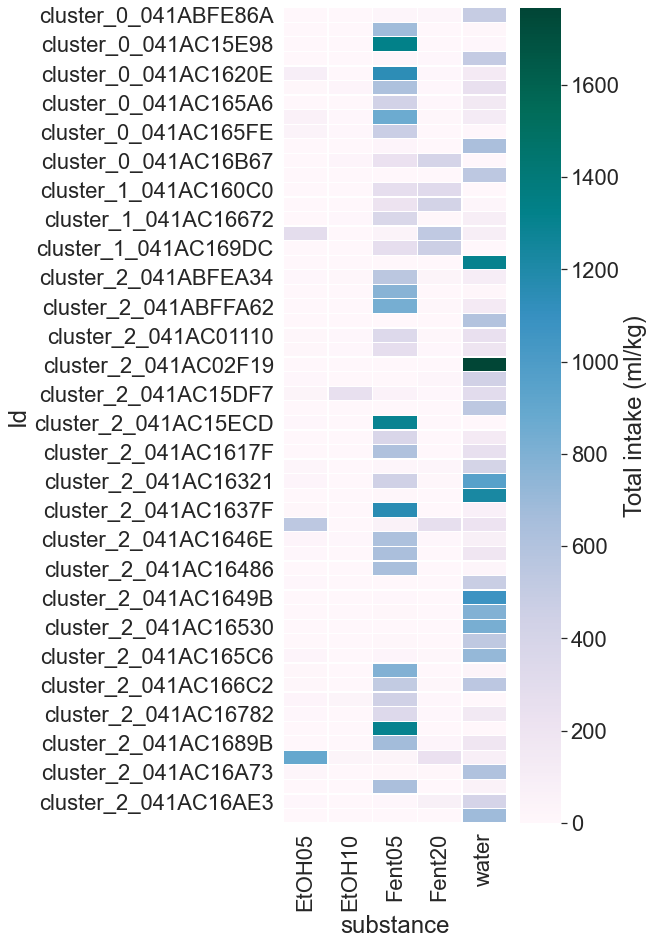

In [142]:
sns.set(font_scale=2)
groupby = data_VDM_total_sub.pivot('Id', 'substance', "intake_ml_kg")
plt.figure(figsize=(5,15))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, 
                     cbar_kws={'label': 'Total intake (ml/kg)'})

#plt.xlabel('Bottle')
plt.show()